In [13]:
options(warn=-1)
rm(list=ls())
library(ranger)
library(MASS)
library(readxl)
library(class)
library(gmodels)
library(dplyr)
library(eqs2lavaan)
library(reshape2)
library(purrr)
library(tidyr)
library(ggplot2)
require(caTools)
library(corrplot)
library(RColorBrewer)

In [14]:
# Read data from excel file
# since there is more than one sheet in our file and our intrest not in first sheet; we have to cpecify sheet.

# sheet_name <- "Sheet1"
# data <- read_excel("data.xlsx", sheet = sheet_name)
# data <- data.frame(data)

# Read data from Rdata file (converted from excel file)
data <- readRDS(file = "data.rds")

data$LoanTenor <- tolower(data$LoanTenor)
data$SectorDescription[data$SectorDescription == "OTHERS"] <- "Others"

# adding Primary_key column, by murgin 2 existing columns
data['Primary_key'] <- paste(as.character(data$applicationnumber), as.character(data$loantype), sep="")

In [15]:
# distribution of <DataType> 
count(data, DataType)

DataType,n
New,80362
Old,255929


In [16]:
# observations where  <DataType> and <Primary_key> both are same
a = data %>% count(DataType, Primary_key) %>% filter(n > 1)
data[data$Primary_key == a$Primary_key, ]

applicationnumber,loantype,DisbursalDate,LoanTenor,LoanAmount,SectorDescription,EstablishedSinceMonths,CurrentAddressSinceMonths,DocumentCharge,EMI,⋯,OtherLoanBank,NoOfDependents,Qualification,NetBusinessIncome,NetDisposableIncome,ProfessionDesc,30 DPDs Instance,DPD30,DataType,Primary_key
40122,17,2017-06-17,12 months,1e+05,Services,156,360,2500,10667,⋯,0,5,Illiterate,34920,19410,Self Employed,0,0,New,4012217
40122,17,2017-06-17,12 months,1e+05,Services,156,360,2500,10667,⋯,0,5,Illiterate,34920,19410,Self Employed,0,0,New,4012217


In [17]:
str(data)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	336291 obs. of  29 variables:
 $ applicationnumber        : num  321071 240464 288229 206150 256515 ...
 $ loantype                 : num  8 8 8 8 8 8 8 8 8 8 ...
 $ DisbursalDate            : POSIXct, format: "2016-11-19" "2015-07-16" ...
 $ LoanTenor                : chr  "12 months" "12 months" "12 months" "12 months" ...
 $ LoanAmount               : num  50000 50000 100000 100000 120000 100000 150000 150000 150000 50000 ...
 $ SectorDescription        : chr  "Services" "Services" "Services" "Trading" ...
 $ EstablishedSinceMonths   : num  60 36 168 72 204 144 156 0 0 24 ...
 $ CurrentAddressSinceMonths: num  0 240 584 84 240 36 672 684 60 60 ...
 $ DocumentCharge           : num  1250 1000 4200 3000 3000 3000 1000 2700 3000 1000 ...
 $ EMI                      : num  5333 5420 10667 10670 10800 ...
 $ InterestRate             : num  28 30 28 28 28 28 25.5 25.5 26 30 ...
 $ InsuranceRate            : num  0 1.1 0 1.1 1.1 1.35 1.1 0 0 1.1 ..

In [18]:
summary(data)

 applicationnumber    loantype      DisbursalDate                
 Min.   :     9    Min.   : 8.000   Min.   :2012-01-03 00:00:00  
 1st Qu.:109618    1st Qu.: 8.000   1st Qu.:2014-09-12 00:00:00  
 Median :216183    Median : 8.000   Median :2016-01-26 00:00:00  
 Mean   :201764    Mean   : 9.452   Mean   :2015-09-16 11:30:25  
 3rd Qu.:298300    3rd Qu.: 8.000   3rd Qu.:2016-11-07 00:00:00  
 Max.   :449618    Max.   :17.000   Max.   :2018-11-29 00:00:00  
                                                                 
  LoanTenor           LoanAmount     SectorDescription  EstablishedSinceMonths
 Length:336291      Min.   : 25000   Length:336291      Min.   :    0.00      
 Class :character   1st Qu.: 50000   Class :character   1st Qu.:   24.00      
 Mode  :character   Median : 60000   Mode  :character   Median :   72.00      
                    Mean   : 71573                      Mean   :   97.37      
                    3rd Qu.:100000                      3rd Qu.:  120.00     

# NA'S

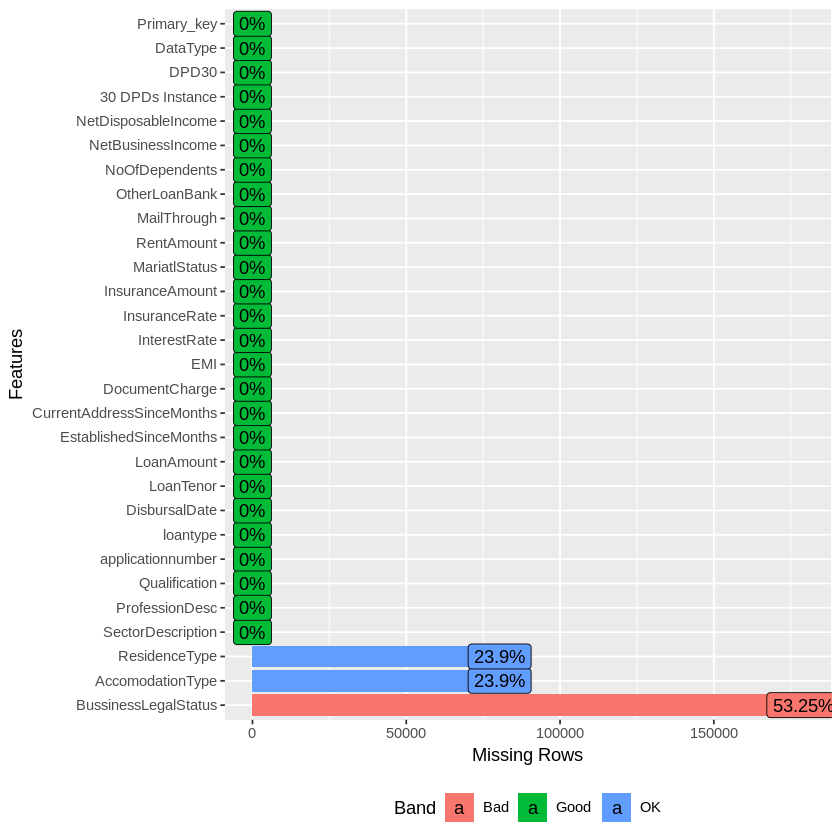

In [19]:
library(DataExplorer)
plot_missing(data)

In [20]:
multi.fun <- function(x) {
      c(min = min(x, na.rm=T), 
        mean = round(mean(x, na.rm=T)), 
        max = max(x, na.rm=T), 
        Count_0=sum(x==0, na.rm=T), 
        Ratio_0=round(mean(x==0, na.rm=T), 3))
}
t(sapply(data %>% keep(is.numeric), multi.fun))

,min,mean,max,Count_0,Ratio_0
applicationnumber,9,201764,449618,0,0.000
loantype,8,9,17,0,0.000
LoanAmount,25000,71573,150000,0,0.000
EstablishedSinceMonths,0,97,32696,78582,0.234
CurrentAddressSinceMonths,0,246,9800,62121,0.185
DocumentCharge,500,1583,5900,0,0.000
EMI,1980,7460,35670,0,0.000
InterestRate,0,28,34,2,0.000
InsuranceRate,0,1,2,173907,0.517
InsuranceAmount,0,486,3825,173911,0.517


In [21]:
table(data$loantype)


     8     17 
282031  54260 

In [22]:
table(data$AccomodationType)


     0      1      2      3      4      5 
255840     57     14      6      2     10 

In [23]:
table(data$ResidenceType)


     0      1      2      3      4      5 
183161  10320  61894    230     16    308 

In [24]:
summary(data$RentAmount)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0     144       0  120000 

In [25]:
summary(data$OtherLoanBank)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   0.000    0.000    0.000    4.927    0.000 2852.000 

In [26]:
table(data$NoOfDependents)


    0     1     2     3     4     5     6     7     8     9    10    11    12 
24345  1989 13186 32294 63046 88375 59782 27984 14591  5741  2878   862   464 
   13    14    15    16    17    18    19    20    21    22    23    24    25 
  174    85    52    21    16     5     2    38    17     5     2     6     5 
   29    30    31    32    33    34    35    36    37    40    41    42    43 
    1     5    20     3     4     2     2     7     1    20    34     4     2 
   44    45    47    48    50    51    52    53    54    56    60    61    62 
    1     2     1     6     4    71     1     9     5     1    10    40     2 
   63    65    69    70    71    72    73    74    76    77    80    81    82 
    1     2     5     3     9    12     6     1     3     1     4     4     1 
   84    85    91    92    93    96    97 
    3     4     2     3     2     1     1 

In [27]:
summary(data$NetBusinessIncome)

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-292458950      23162      29775      28487      36700     913600 

In [28]:
summary(data$NetDisposableIncome)

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-1.260e+09  0.000e+00  1.595e+04  9.605e+03  2.225e+04  8.892e+05 

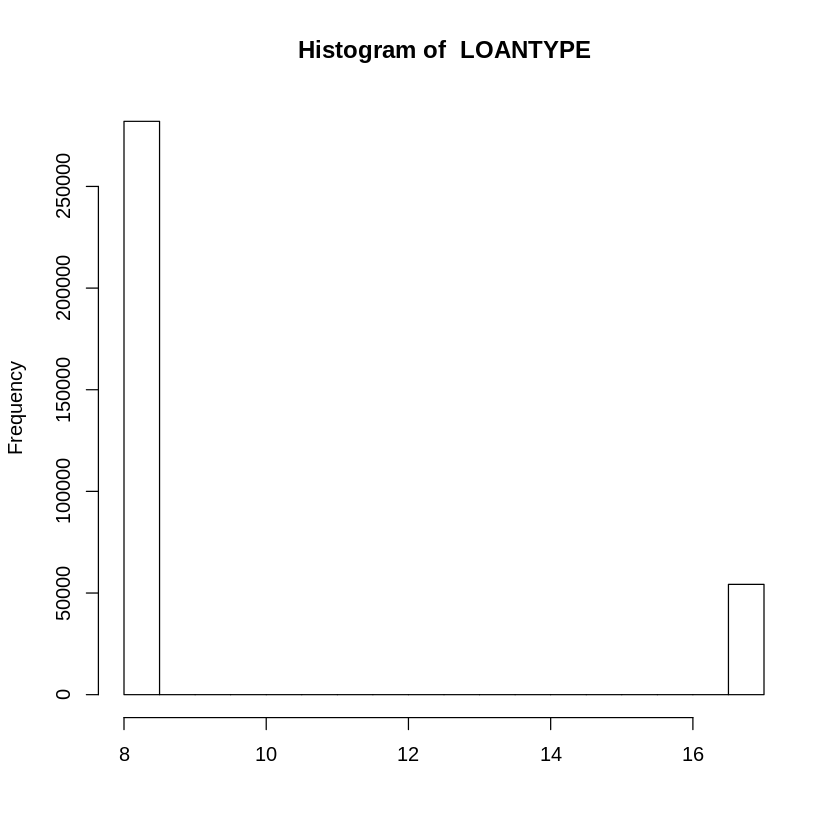

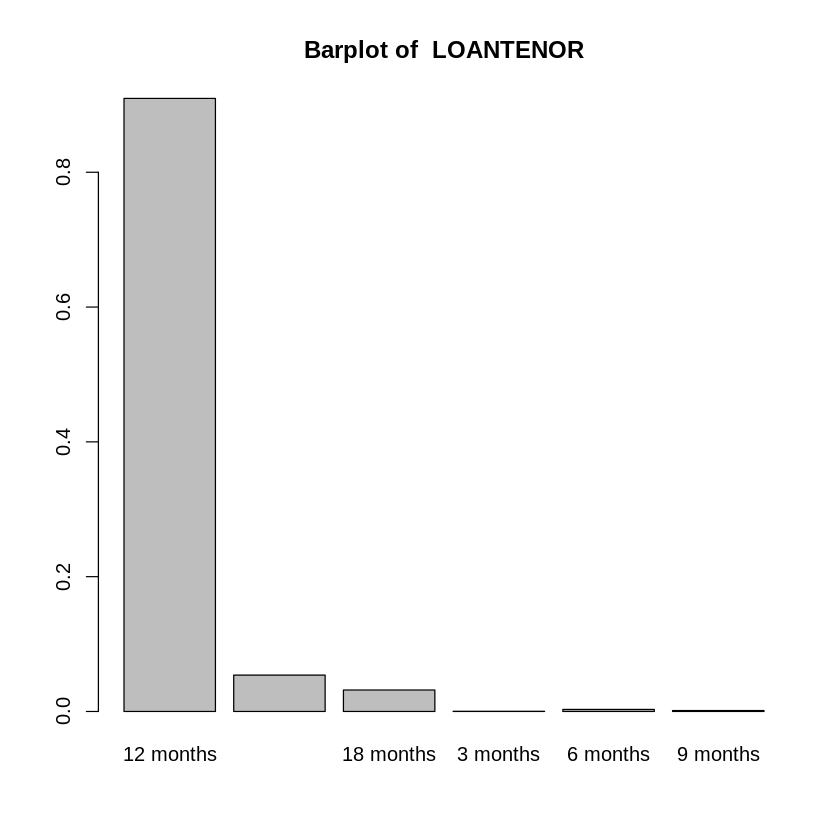

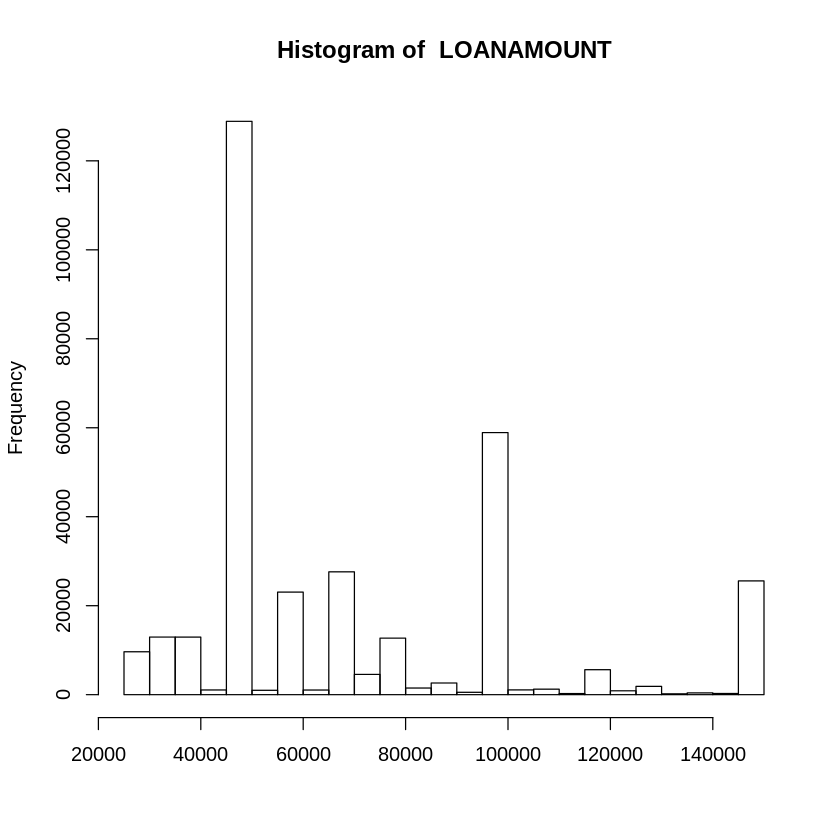

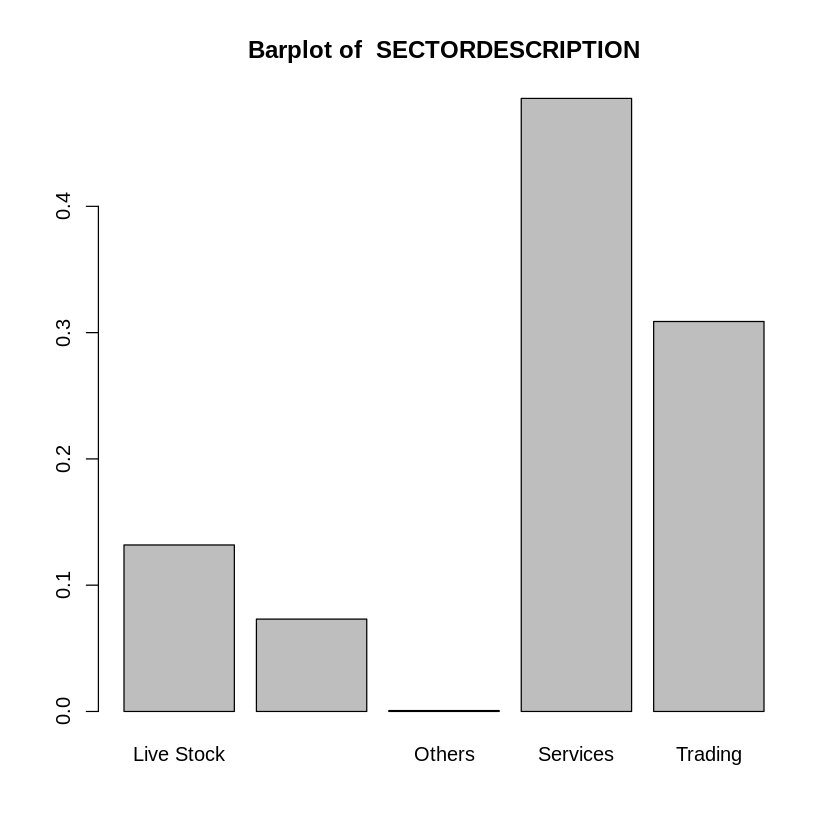

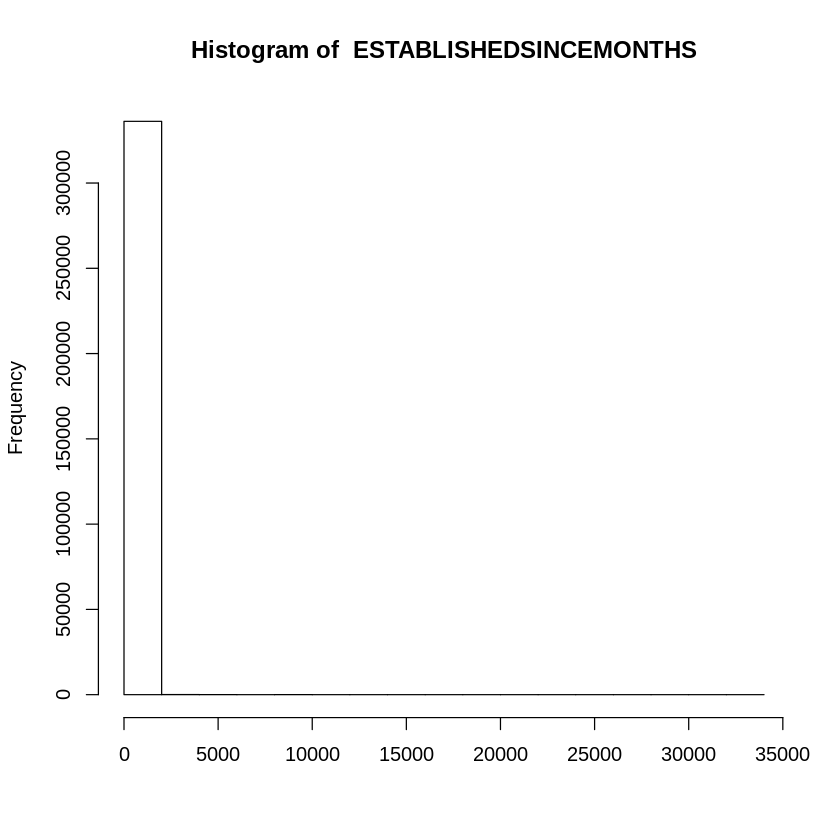

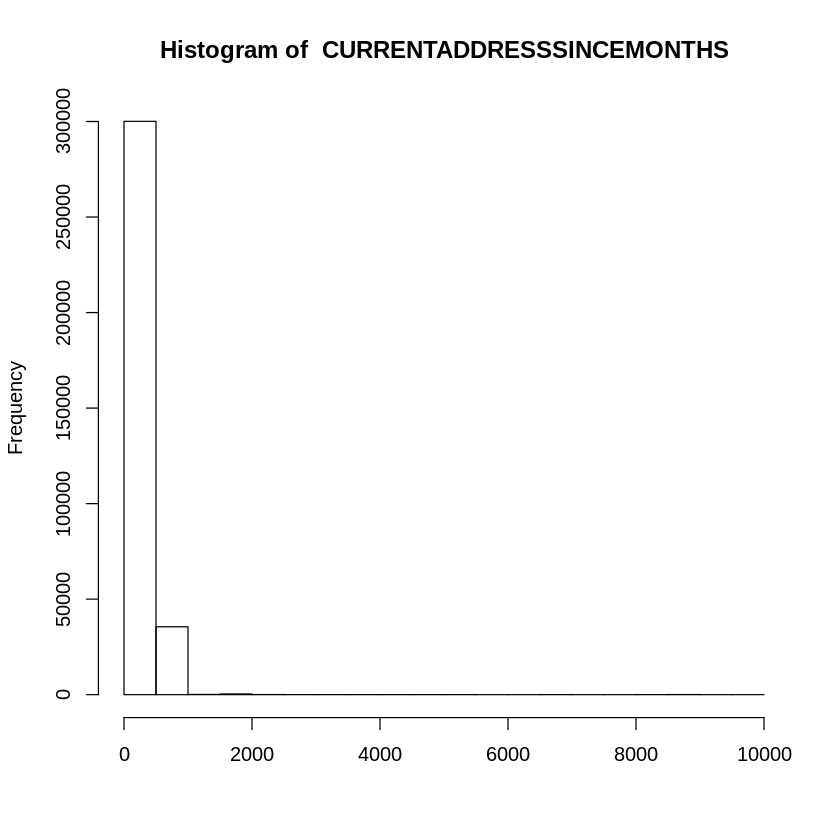

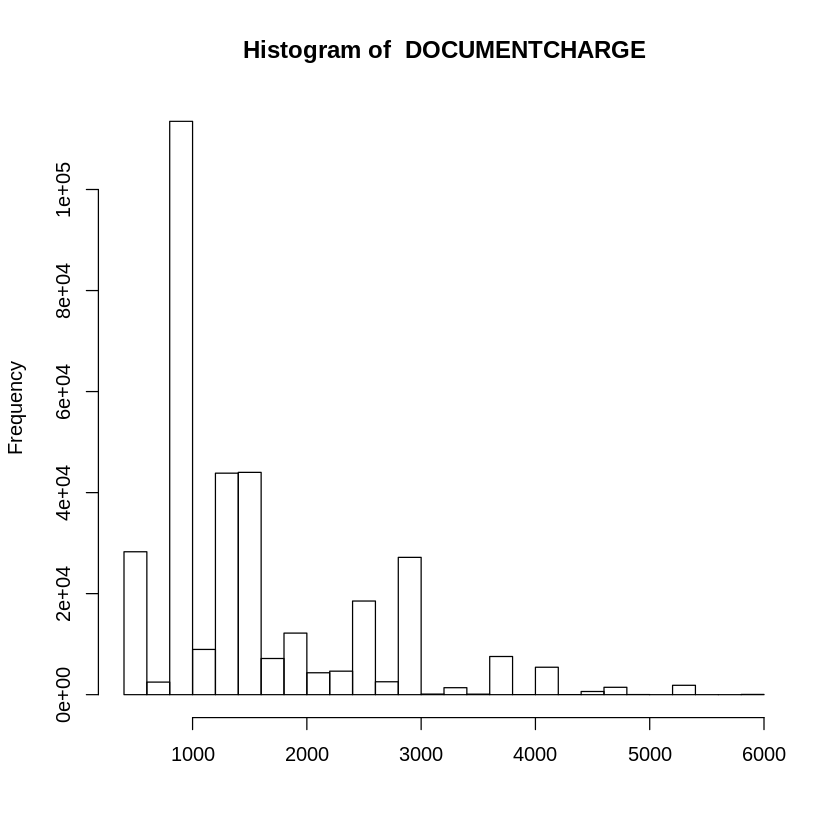

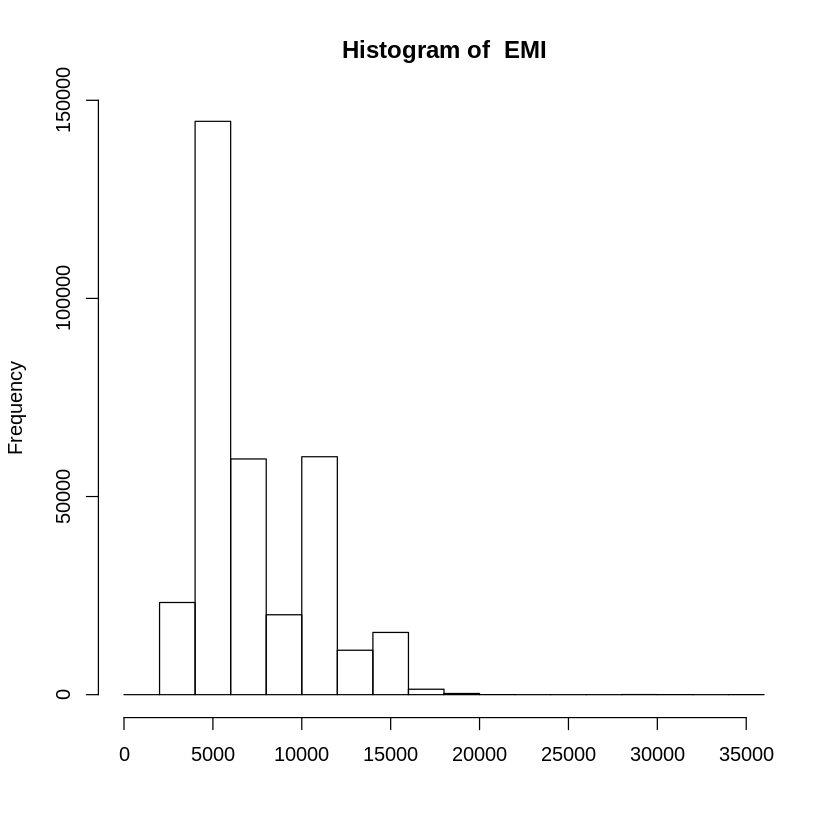

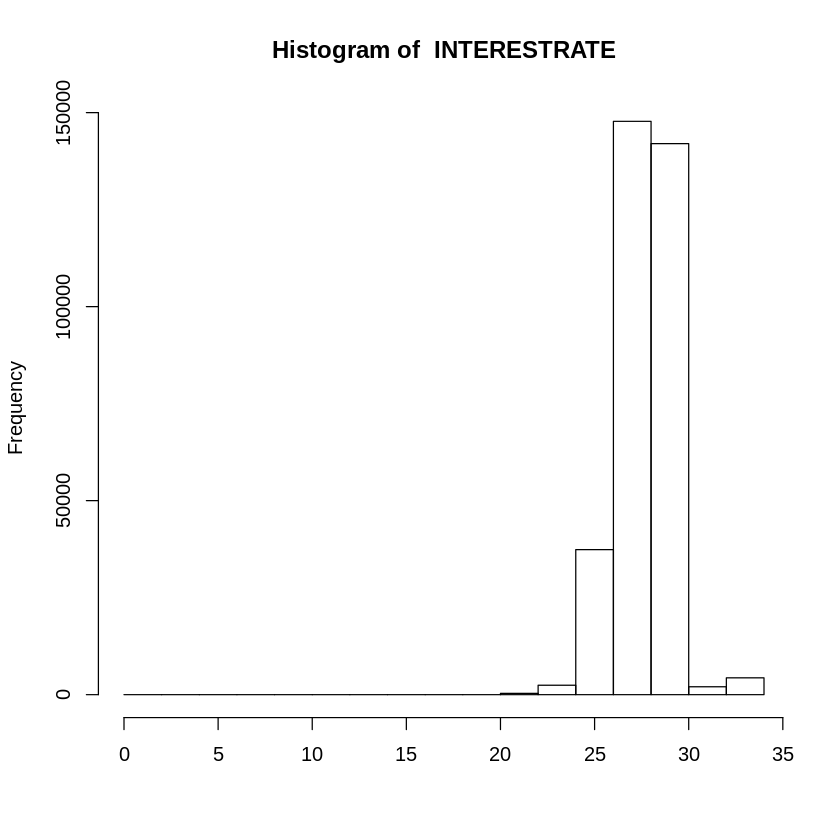

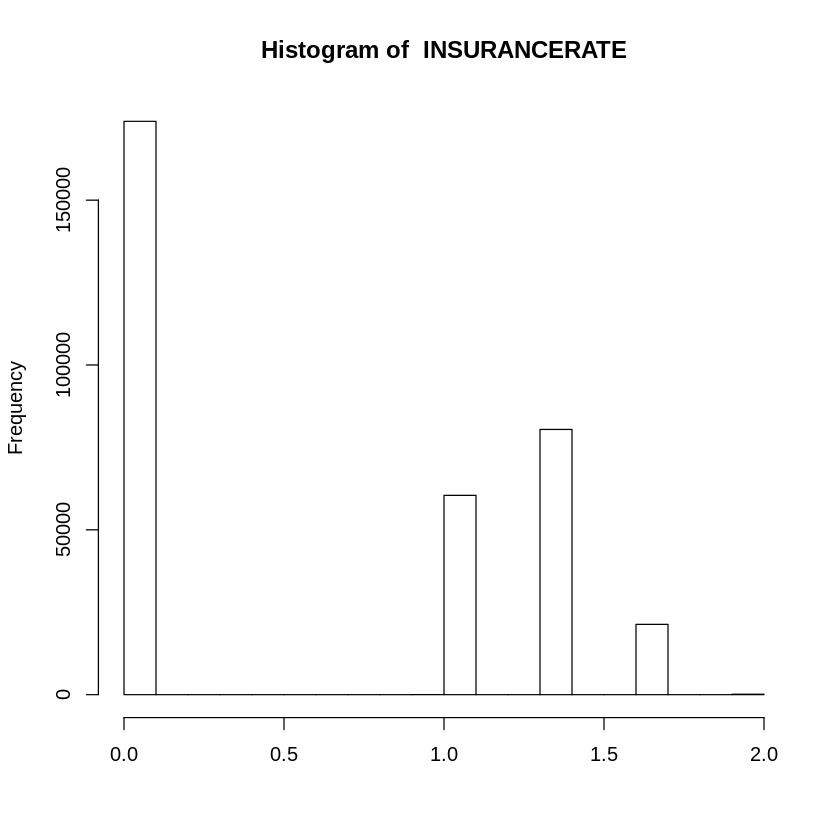

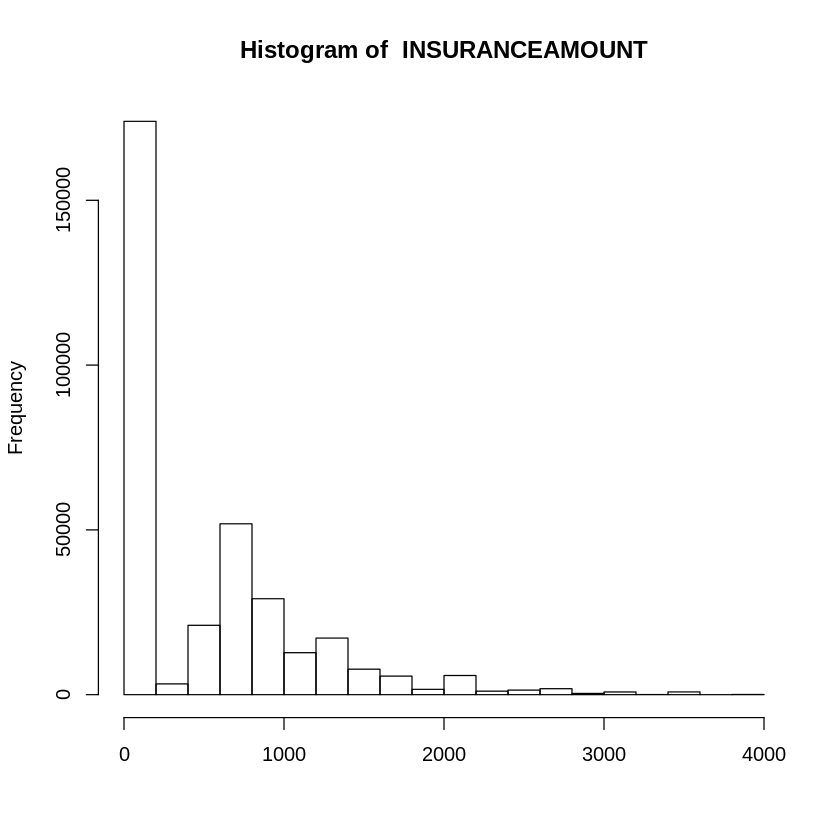

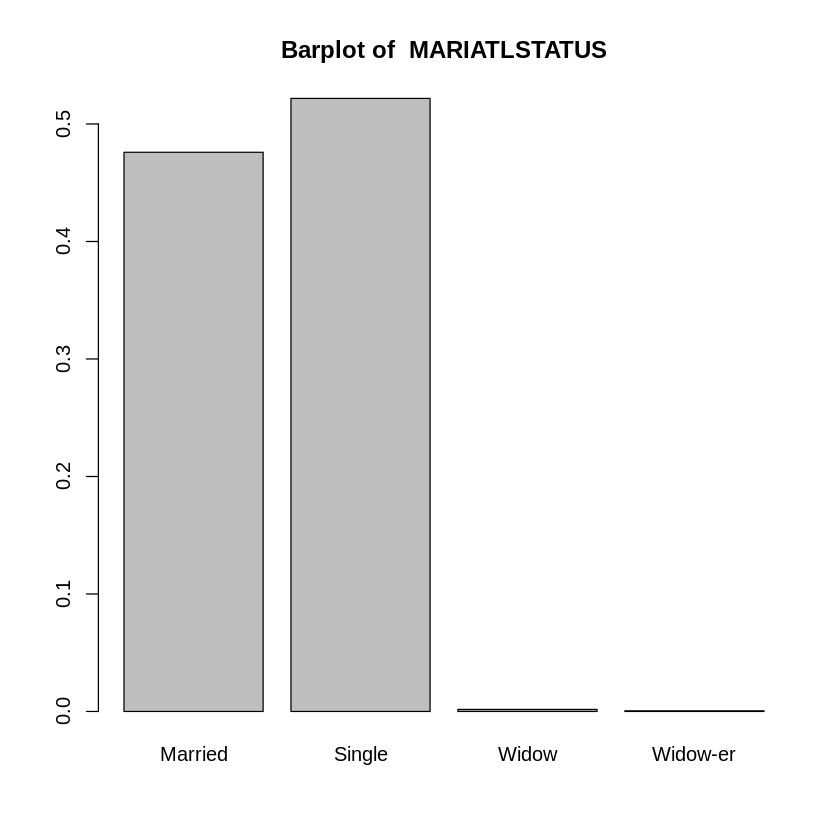

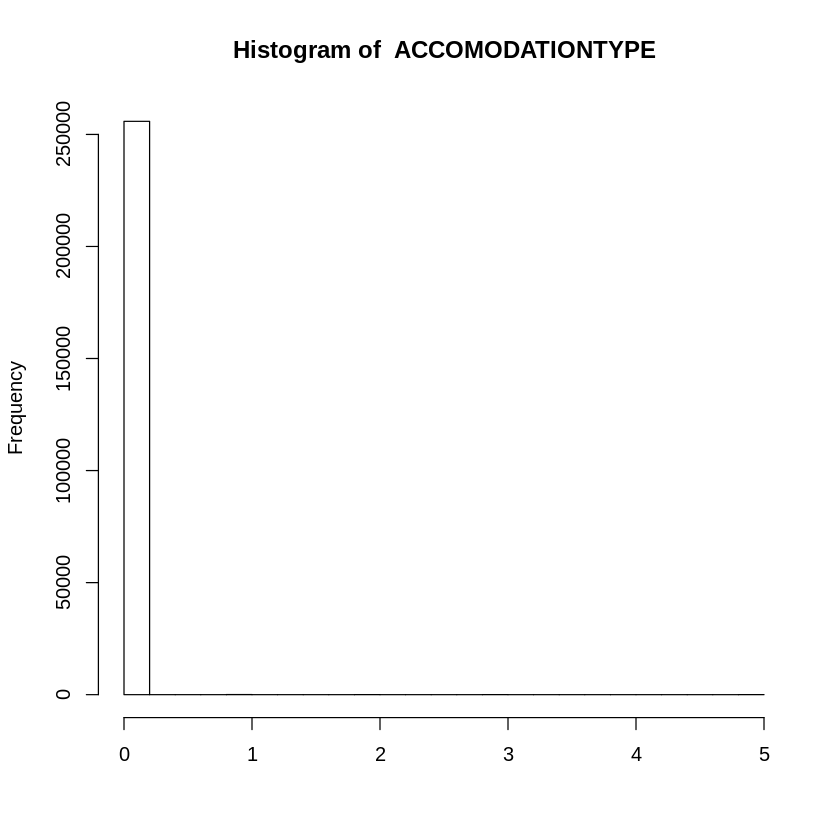

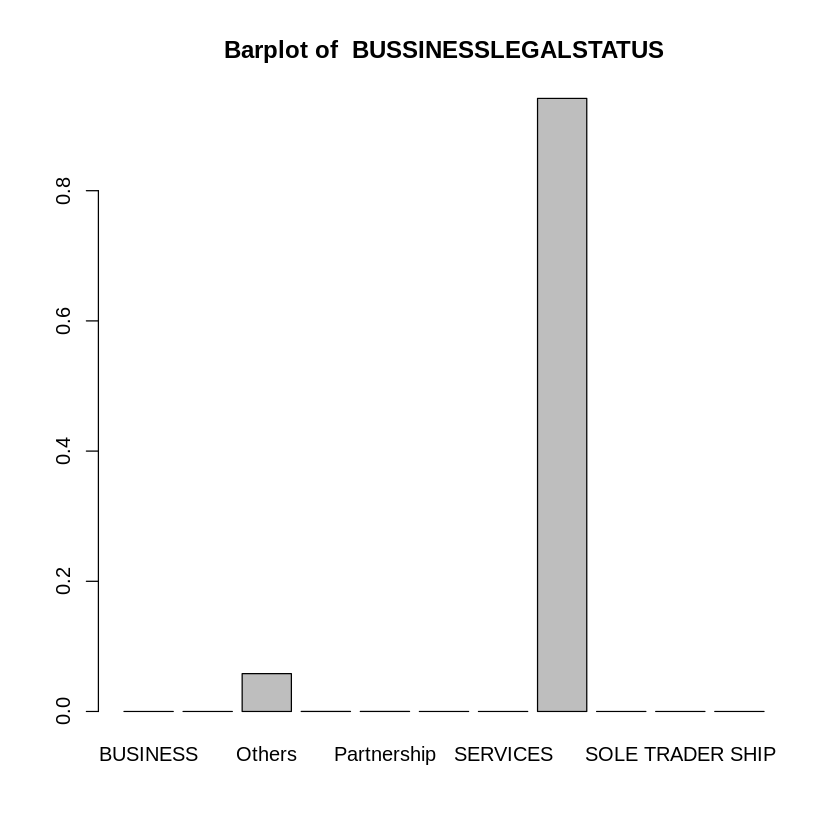

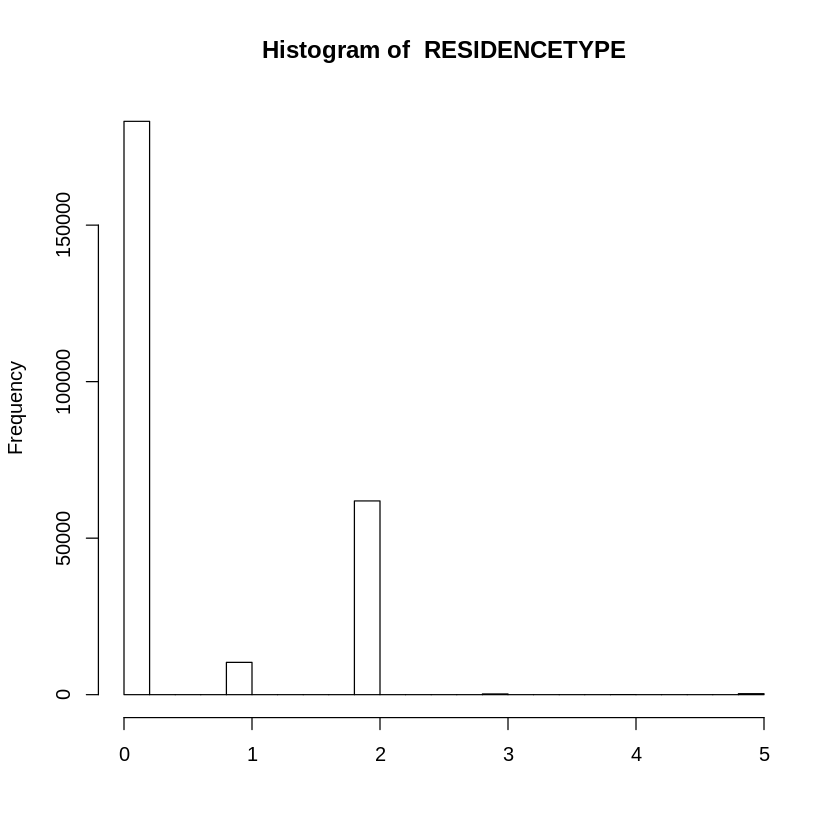

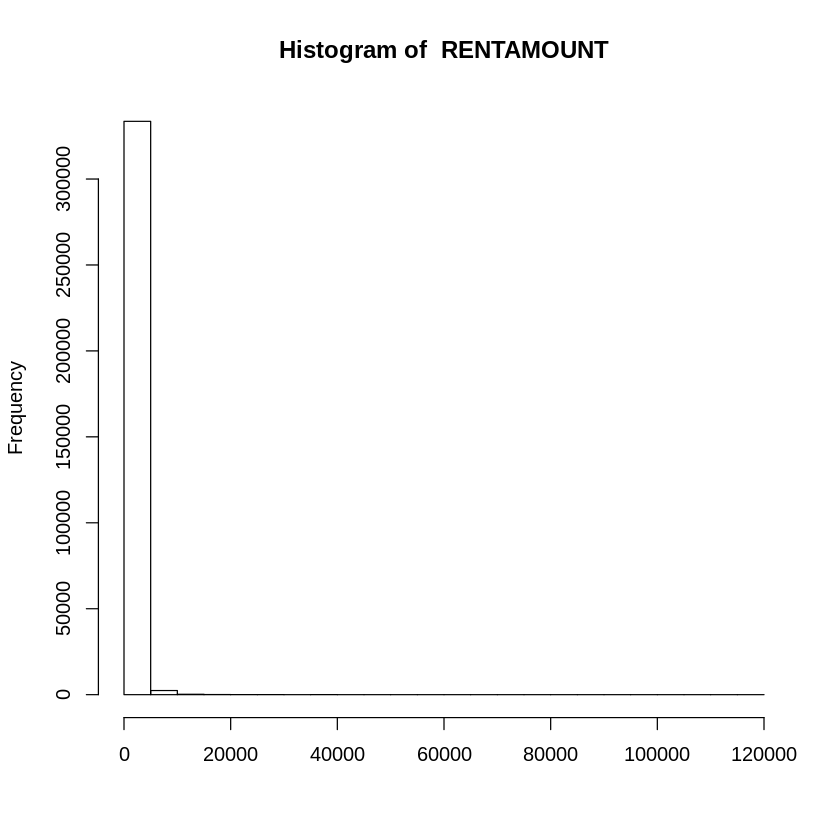

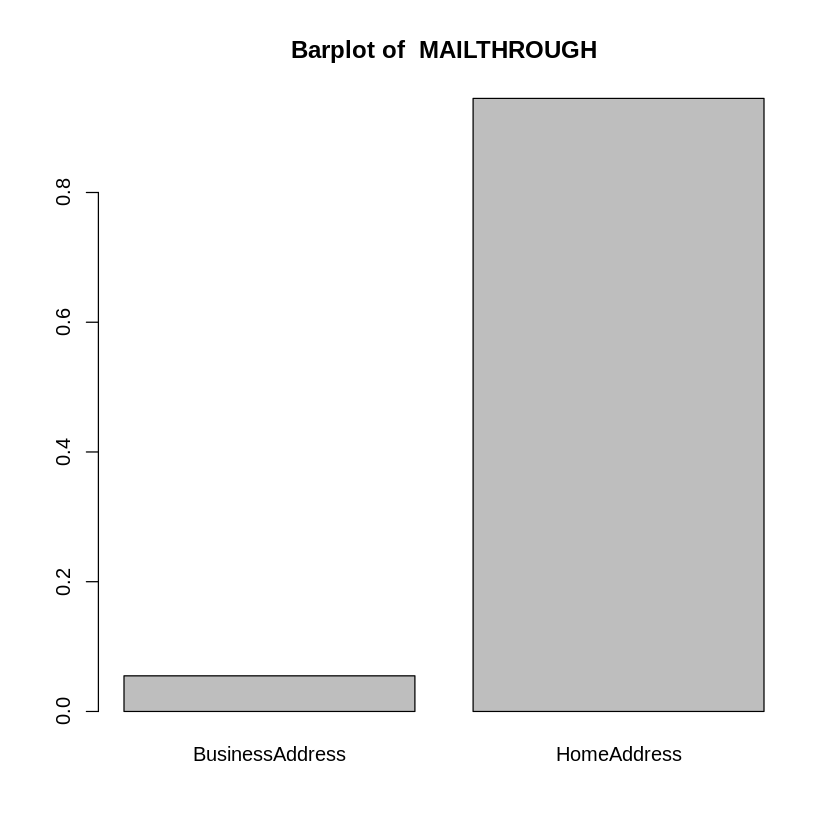

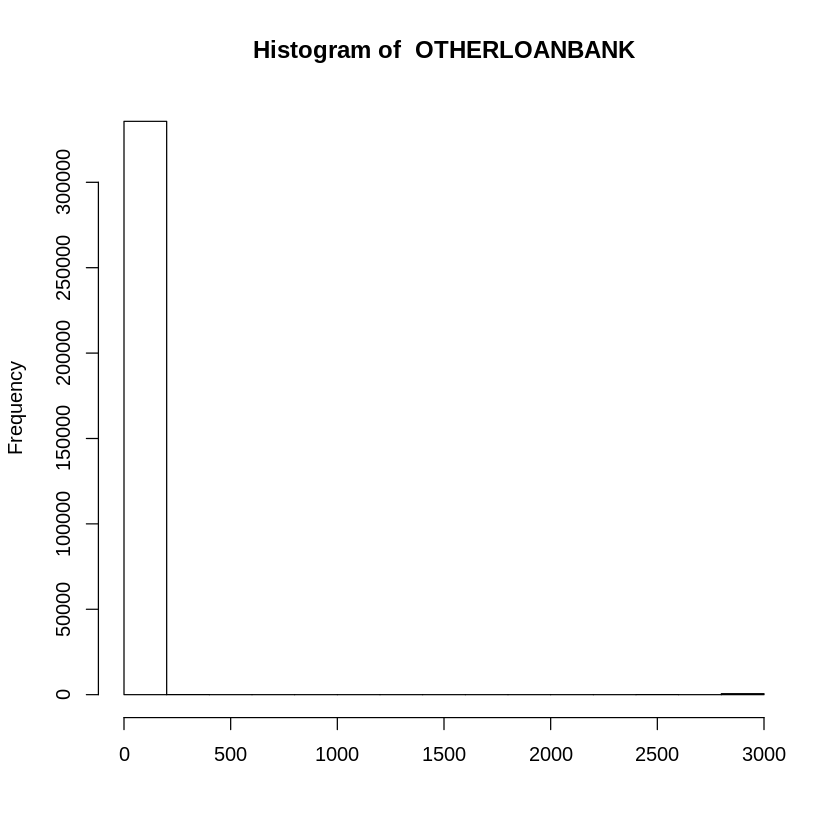

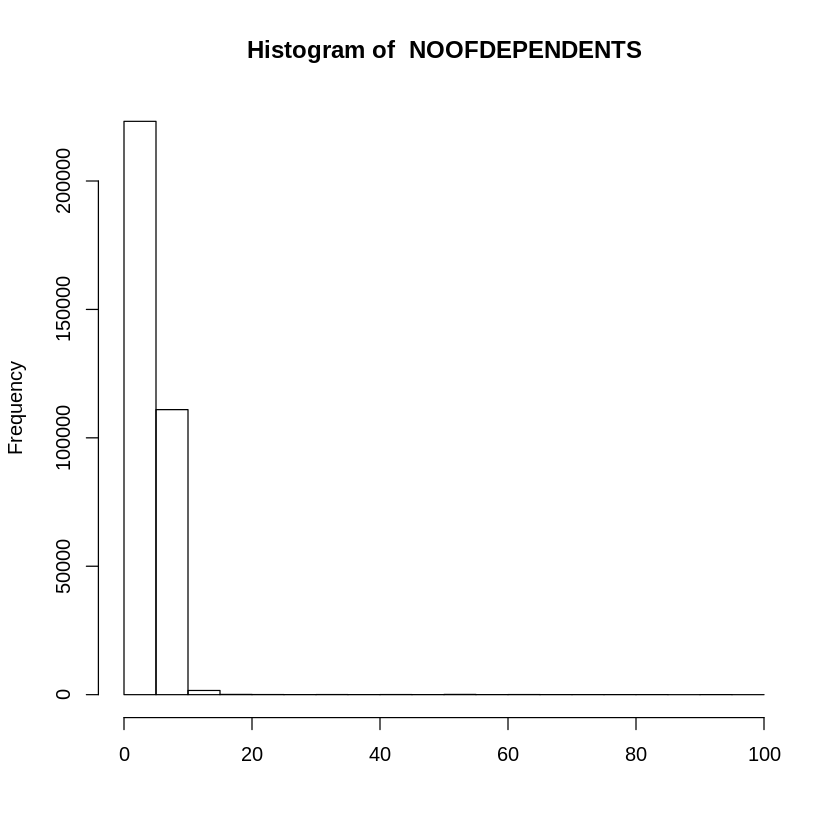

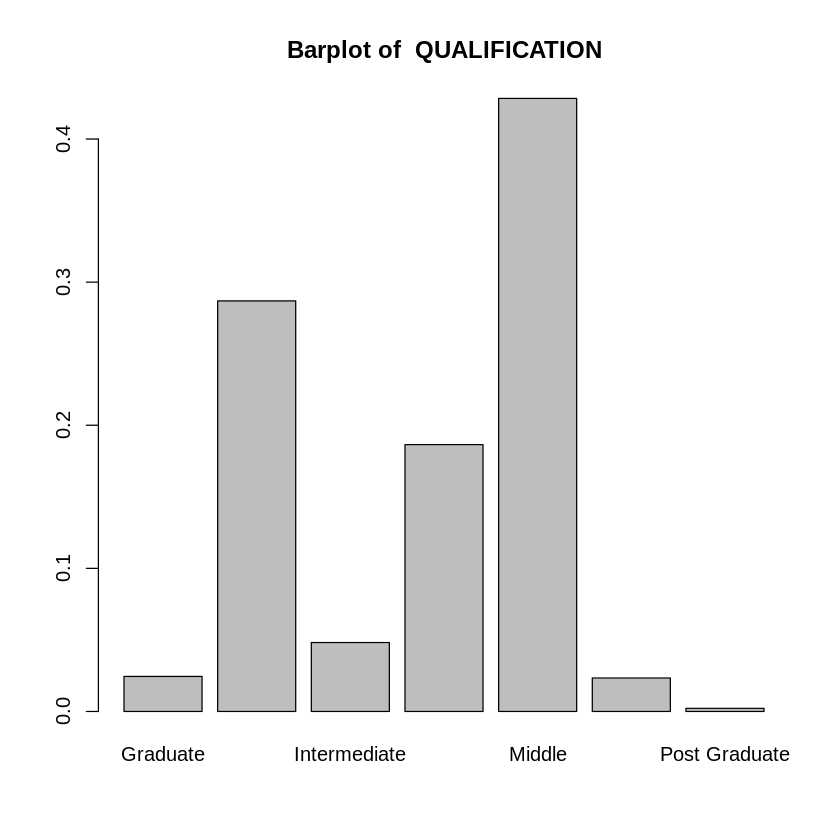

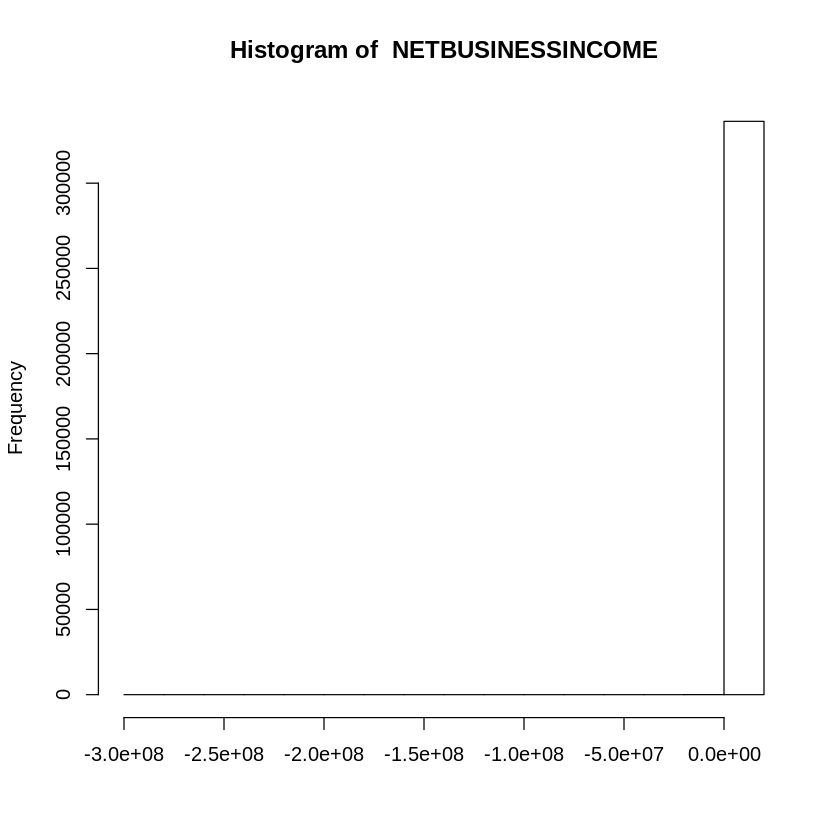

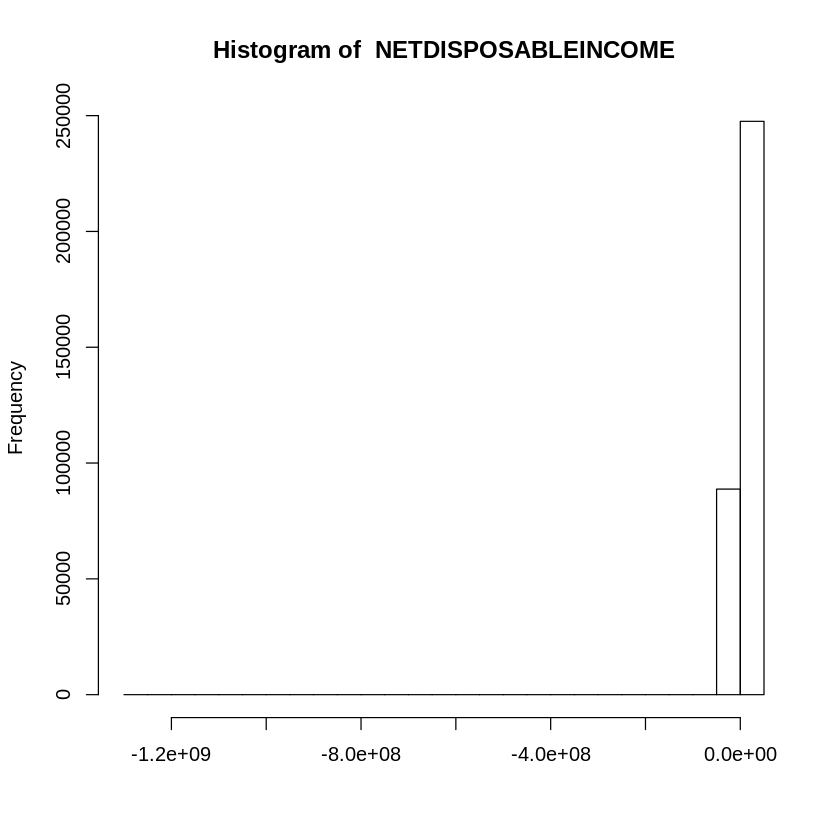

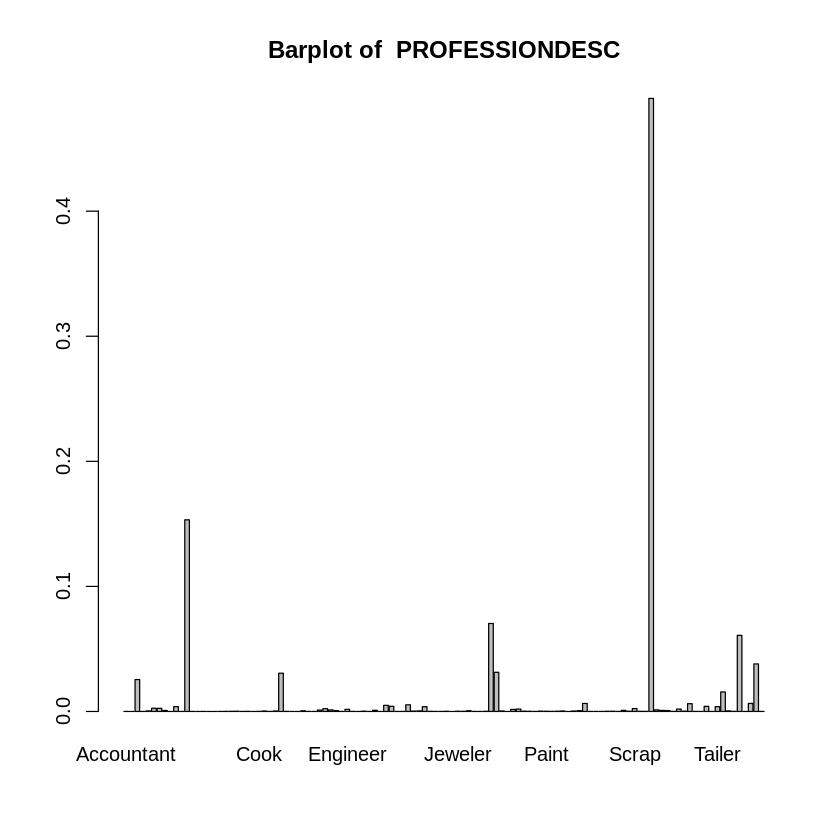

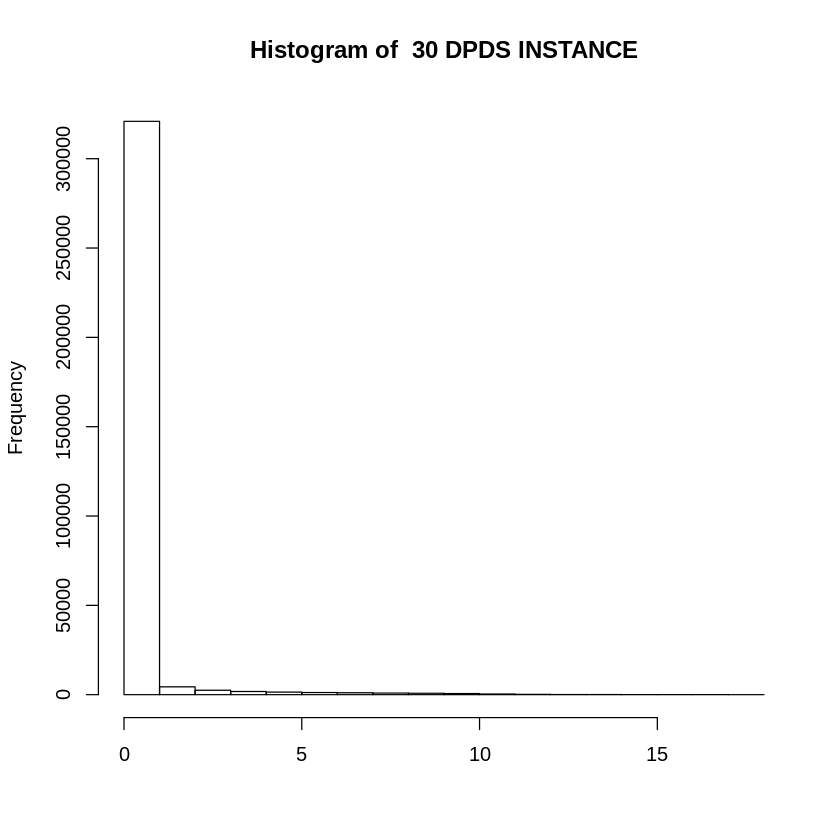

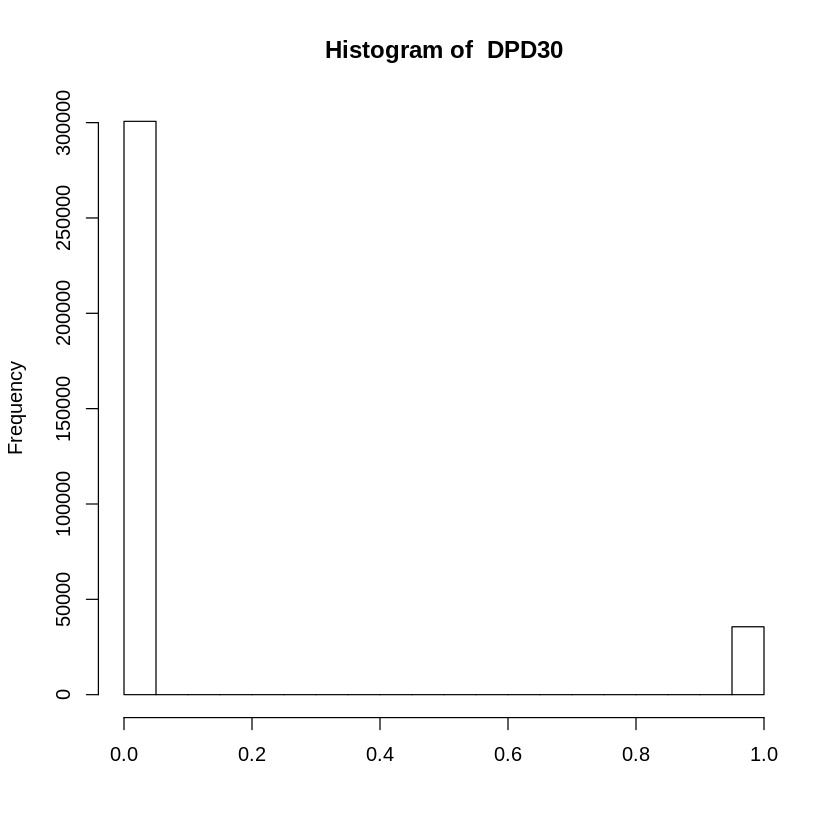

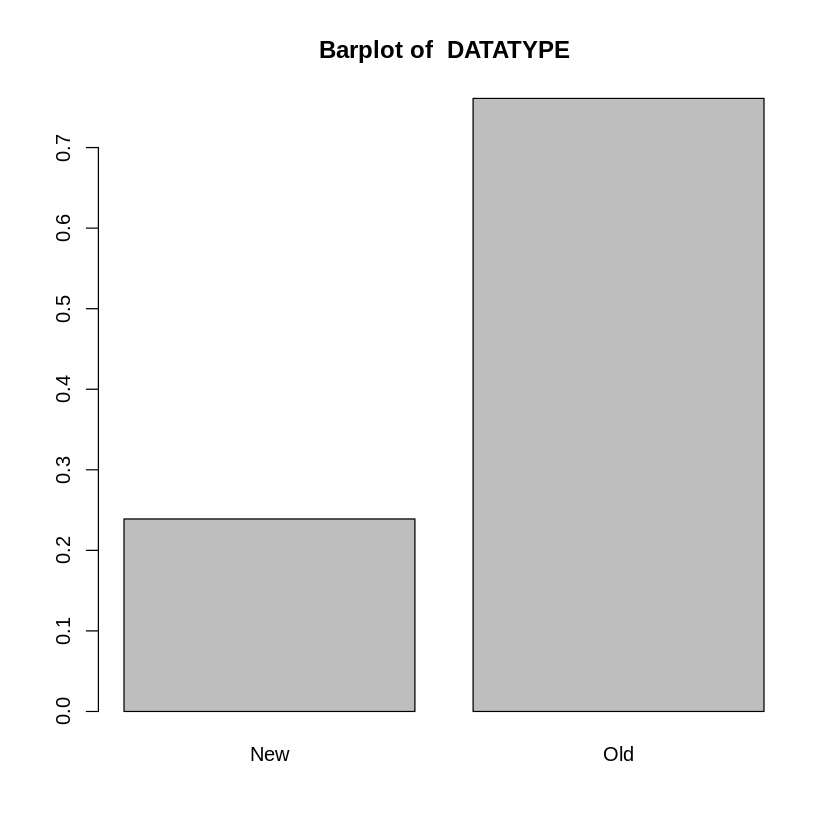

In [29]:
variables_distribution_graphs <- function(dataframe){
    dataframe <- dataframe[!names(dataframe) %in% c("Primary_key", "applicationnumber")]
    for (i in names(dataframe)){
        if (is.numeric(dataframe[[i]])){
            hist(dataframe[[i]], xlab = "", main = paste("Histogram of ", toupper(i)))
    }
        else if (is.character(data[[i]])){
            barplot(prop.table(table(dataframe[[i]])), main = paste("Barplot of ", toupper(i)))
}}}
variables_distribution_graphs(data)

# Q1- There is a column for data type which includes only two values i.e. new and old. Please check if there are any loans in new data which also exist in old data. The key for the data is application ID and loan ID i.e. application ID + loan ID is your primary key.

In [30]:
# Only duplicates
old_primary_keys <- data[data$DataType == "Old", ]$Primary_key
new_primary_keys <- data[data$DataType == "New", ]$Primary_key

in_both_new_and_old <- data[data$Primary_key %in% old_primary_keys & 
                            data$Primary_key %in% new_primary_keys,]

in_both_new_and_old %>% group_by(DataType) %>% count()

cat("There is ", nrow(in_both_new_and_old)/2, " Primary keys, which is in both New and Old groups")

DataType,n
New,47762
Old,47762


There is  47762  Primary keys, which is in both New and Old groups

# Q.2-  For any repeated loans, please check if the data in other columns is also the same

In [31]:
duplicated_old <- in_both_new_and_old[in_both_new_and_old$DataType == "Old", ]
duplicated_old <- duplicated_old[order(duplicated_old$Primary_key),]
duplicated_old$Primary_key <- as.integer(duplicated_old$Primary_key)

duplicated_new <- in_both_new_and_old[in_both_new_and_old$DataType == "New", ]
duplicated_new <- duplicated_new[order(duplicated_new$Primary_key),]
duplicated_new$Primary_key <- as.integer(duplicated_new$Primary_key)

# check both column are same or not
identical(duplicated_old$Primary_key, duplicated_new$Primary_key)

data <- data[, !(names(data) == "DataType")]

merged <- merge(duplicated_old, duplicated_new, by = names(data))
cat("We have ", nrow(merged), " duplicated row/s(except column DataType).")

[1] TRUE

We have  0  duplicated row/s(except column DataType).

In [32]:
matching <-  data.frame(duplicated_new == duplicated_old)
names(matching) <- names(duplicated_new)
# write.csv(in_both_new_and_old, 'in_both_new_and_old.csv')

l = c()
for (i in names(matching)) {
  l <- append(l, 
              c(i, 
                sum(matching[, i], na.rm = T), 
                mean(matching[,i], na.rm = T))
             )
}

ratio_of_same_entry_both_time = data.frame(matrix(l, byrow = T, ncol = 3))
ratio_of_same_entry_both_time <- ratio_of_same_entry_both_time[order(ratio_of_same_entry_both_time$X3, decreasing = F), ]
names(ratio_of_same_entry_both_time) <- c("Variable_Name", "Count of: old == new", "Ratio of: old == new")

ratio_of_same_entry_both_time

,Variable_Name,Count of: old == new,Ratio of: old == new
28,DataType,0,0
3,DisbursalDate,1290,0.0270089192244881
8,CurrentAddressSinceMonths,14882,0.311586616975839
7,EstablishedSinceMonths,18998,0.397763912733973
25,ProfessionDesc,31119,0.651543067710732
10,EMI,36608,0.766467065868264
11,InterestRate,39759,0.832440015074746
16,BussinessLegalStatus,36997,0.939224695996547
19,MailThrough,47123,0.98662116326787
24,NetDisposableIncome,47349,0.991352958418827


# Q.3: I want you to compare variable distributions in new vs old data and document any significant changes

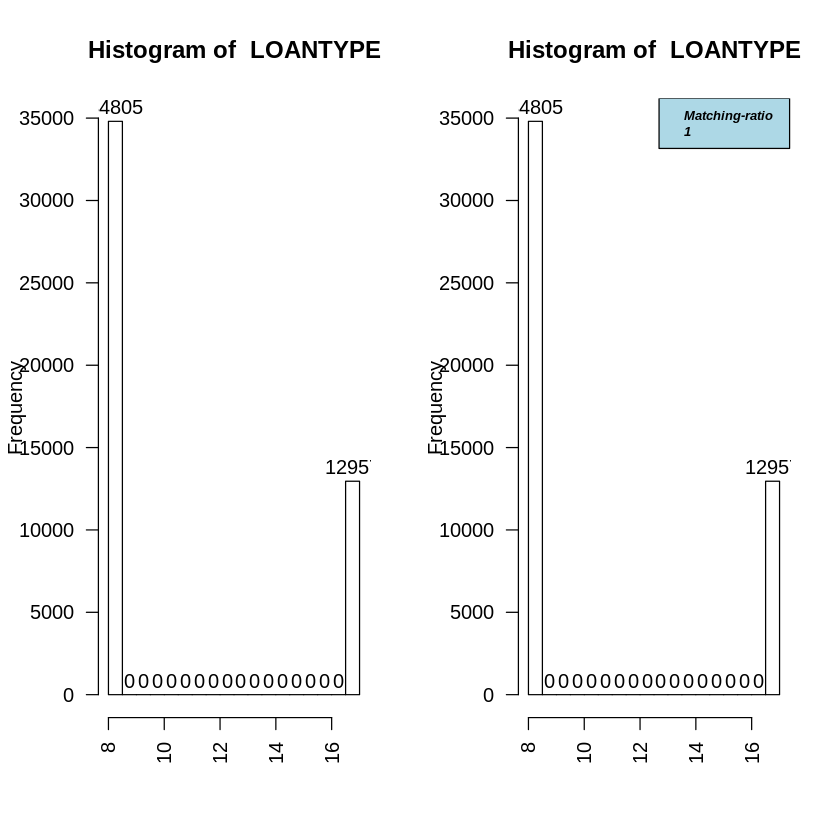

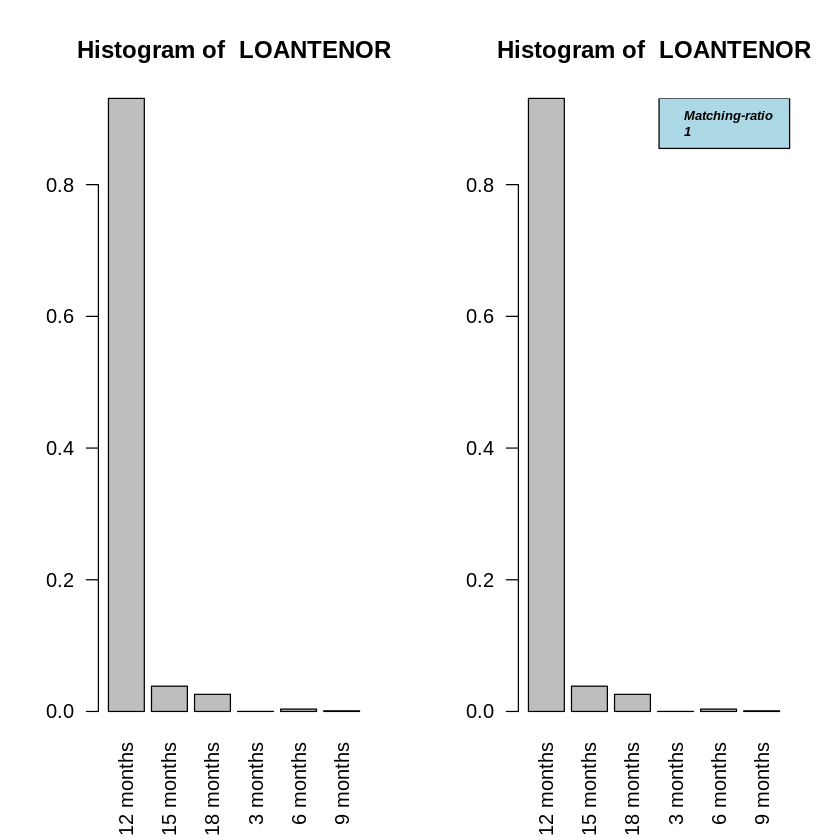

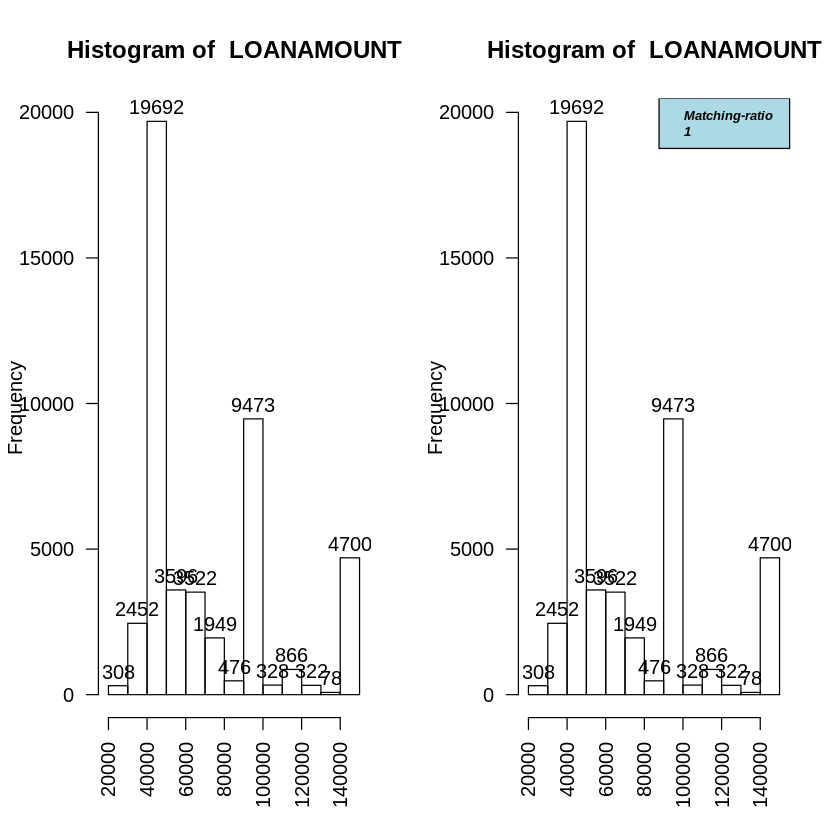

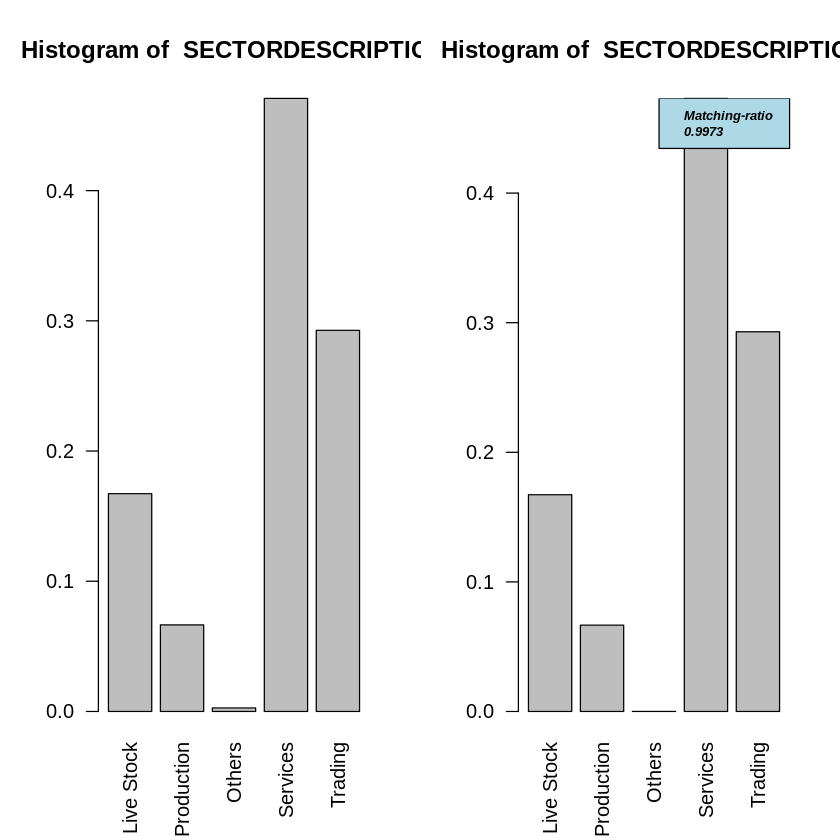

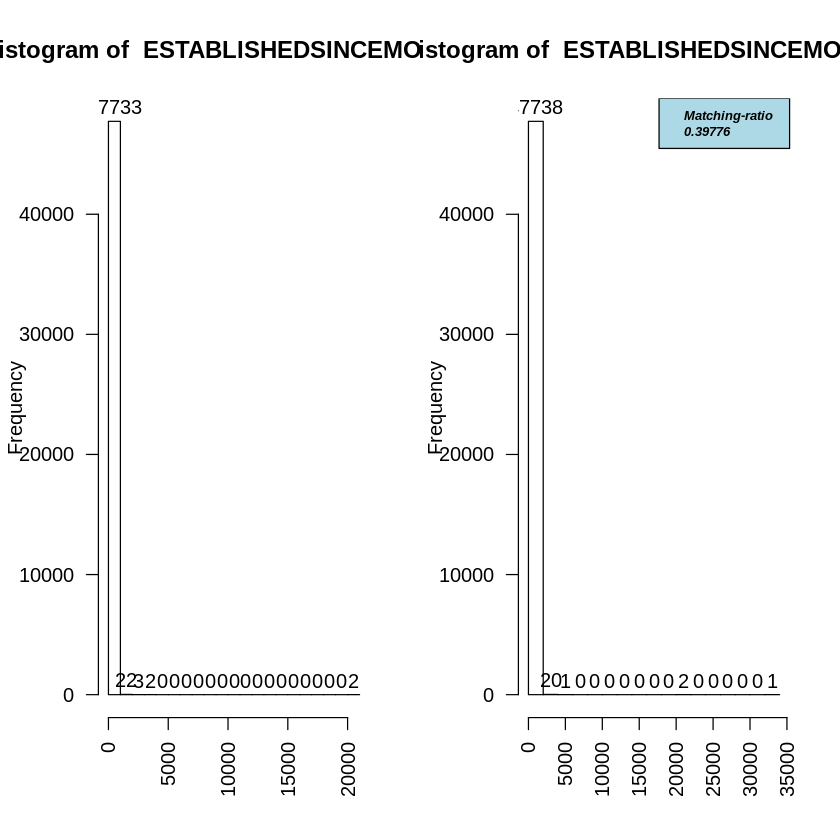

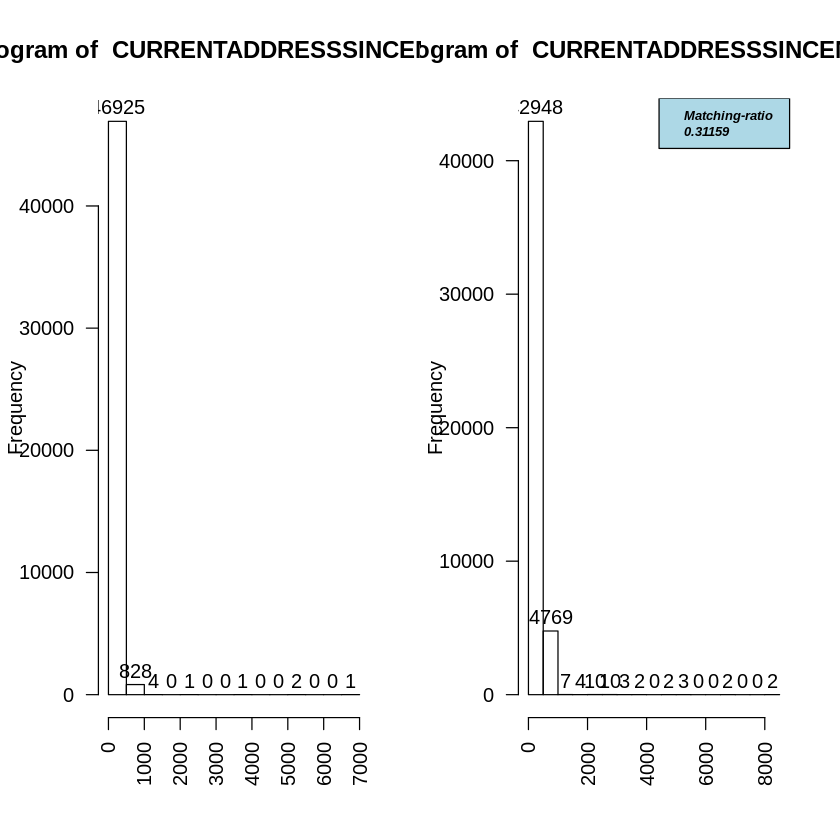

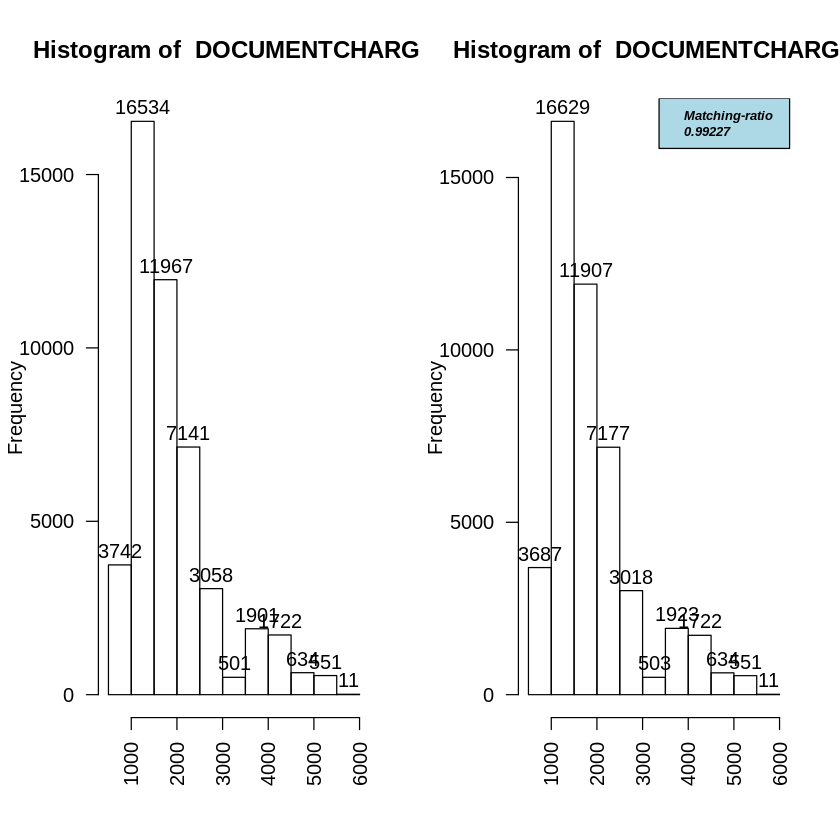

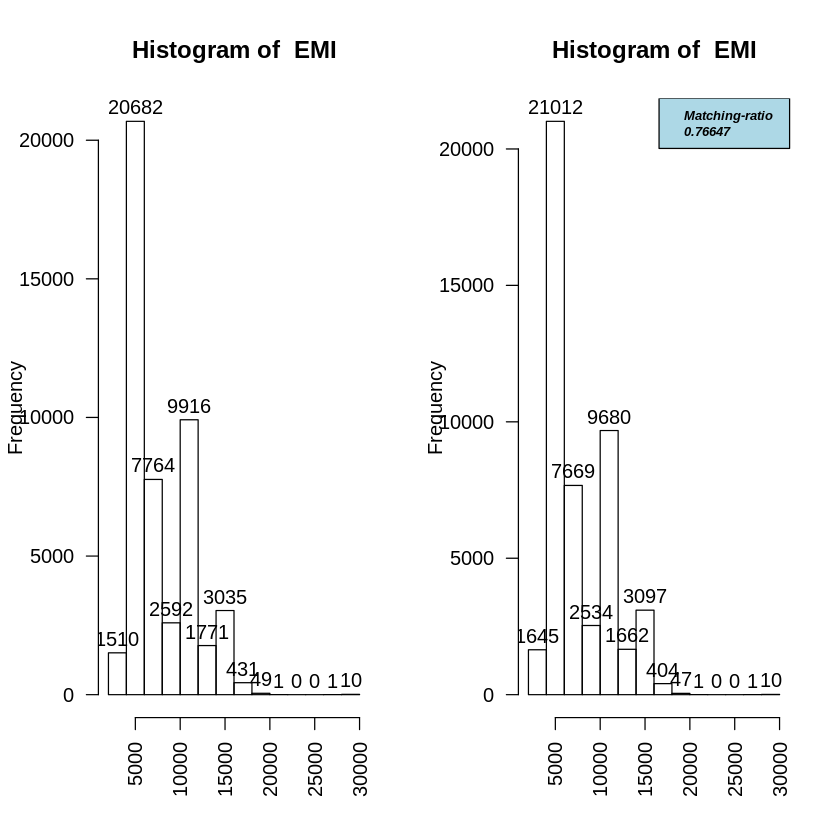

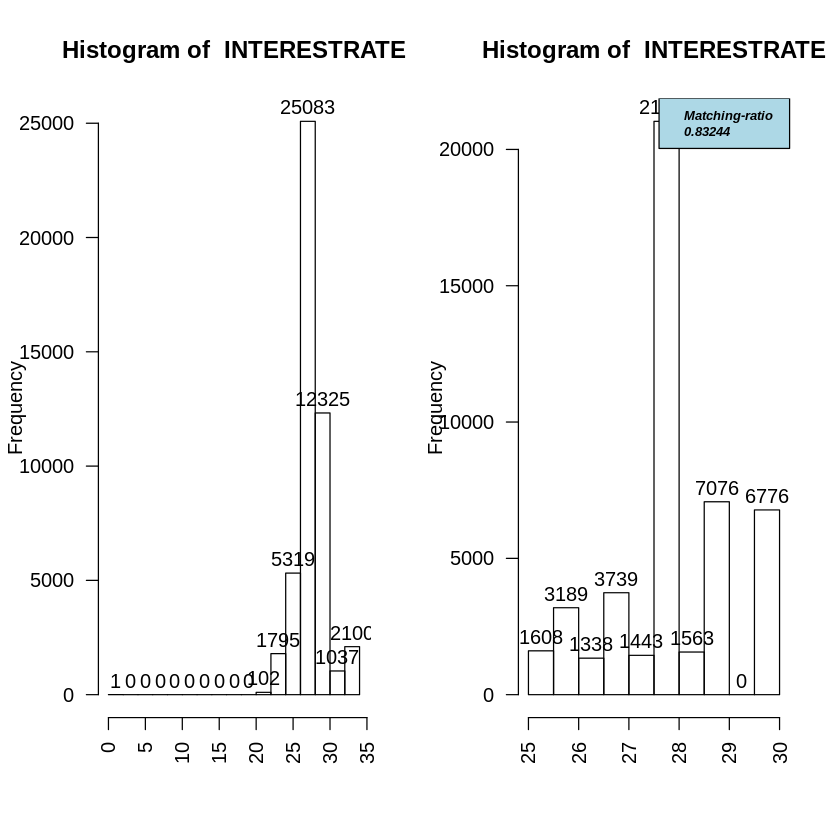

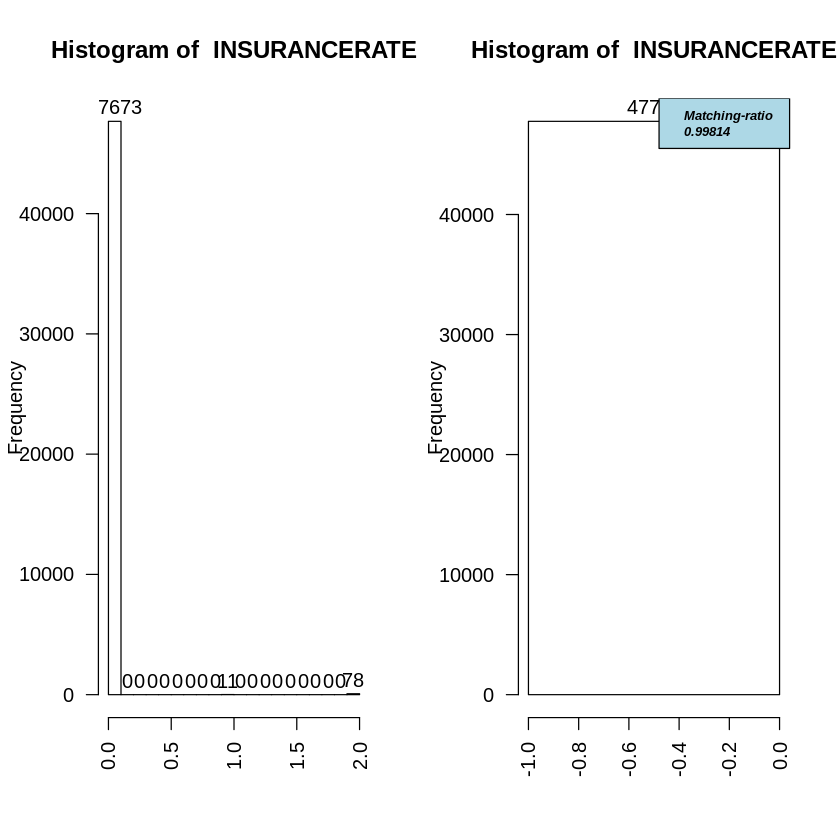

ERROR: Error in hist.default(duplicated_new[[i]], main = paste("Histogram of ", : invalid number of 'breaks'


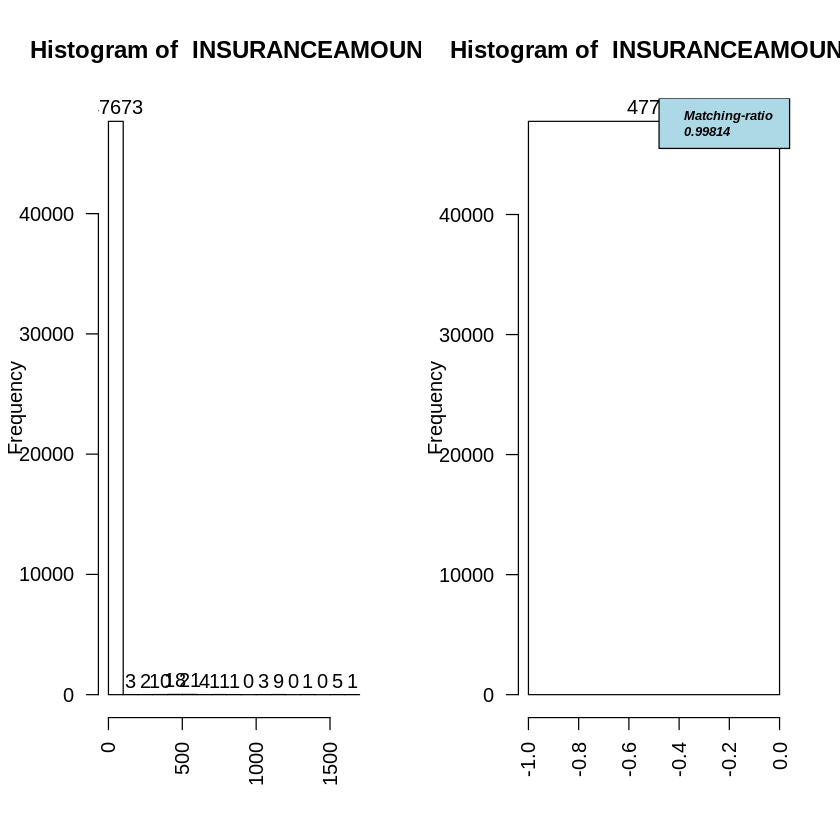

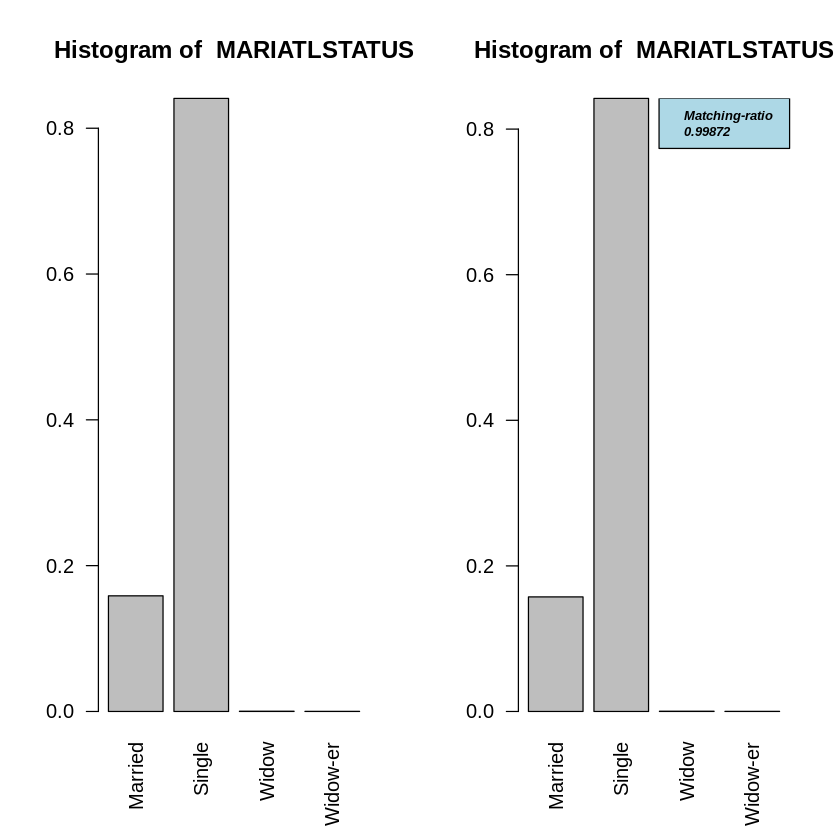

In [33]:
for (i in names(duplicated_new)){
    if (is.numeric(duplicated_new[[i]]) & i != "Primary_key" & i != "applicationnumber"){
        par(mfrow=c(1,2))
            hist(duplicated_new[[i]], main=paste("Histogram of ", toupper(i)), xlab = "", labels = T, ,las=2)
            hist(duplicated_old[[i]], main=paste("Histogram of ", toupper(i)), xlab = "", labels = T, ,las=2)
            legend('topright', legend=c("Matching-ratio", 
                                 round(mean(matching[[i]]), 5)),
                   cex=0.65,
                   text.font=4,
                   bg='lightblue'
                  )
}
    else if (is.character(duplicated_new[[i]])){
        par(mfrow=c(1,2))
        barplot(prop.table(table(duplicated_new[[i]])), main = paste("Histogram of ", toupper(i)), las=2)
        barplot(prop.table(table(duplicated_old[[i]])), main = paste("Histogram of ", toupper(i)), las=2)
        legend('topright', legend=c("Matching-ratio", 
                                 round(mean(matching[[i]]), 5)),
                   cex=0.65,
                   text.font=4,
                   bg='lightblue'
                  )
    }}

# Q.5

In [34]:
data <- readRDS(file = "data.rds")
df <- data[data$DataType == "Old", ]

# we should remove useless variable <DataType> which have only one unique value
df <- df[, !(names(df) == "DataType")]
df$LoanTenor <- tolower(df$LoanTenor)

str(df)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	255929 obs. of  27 variables:
 $ applicationnumber        : num  321071 240464 288229 206150 256515 ...
 $ loantype                 : num  8 8 8 8 8 8 8 8 8 8 ...
 $ DisbursalDate            : POSIXct, format: "2016-11-19" "2015-07-16" ...
 $ LoanTenor                : chr  "12 months" "12 months" "12 months" "12 months" ...
 $ LoanAmount               : num  50000 50000 100000 100000 120000 100000 150000 150000 150000 50000 ...
 $ SectorDescription        : chr  "Services" "Services" "Services" "Trading" ...
 $ EstablishedSinceMonths   : num  60 36 168 72 204 144 156 0 0 24 ...
 $ CurrentAddressSinceMonths: num  0 240 584 84 240 36 672 684 60 60 ...
 $ DocumentCharge           : num  1250 1000 4200 3000 3000 3000 1000 2700 3000 1000 ...
 $ EMI                      : num  5333 5420 10667 10670 10800 ...
 $ InterestRate             : num  28 30 28 28 28 28 25.5 25.5 26 30 ...
 $ InsuranceRate            : num  0 1.1 0 1.1 1.1 1.35 1.1 0 0 1.1 ..

In [35]:
# <DPD30> is our target variable
(y_distribution <- df %>% count(DPD30) %>% mutate(Ratio = n/sum(n)))
print(paste("Even without modeling we can pridict Correctly", round(max(y_distribution$n) / nrow(df)*100, 2), "% of time"))

DPD30,n,Ratio
0,227697,0.8896882
1,28232,0.1103118


[1] "Even without modeling we can pridict Correctly 88.97 % of time"


In [36]:
# Top Correlations between numeric variables
cm <- data.frame(round(df %>% keep(is.numeric) %>% cor, 3))
unique(cm[(cm>0.5 | cm < -0.5) & cm != 1])

[1] -0.644  0.618  0.966 -0.683  0.643 -0.610  0.725  0.692

In [37]:
# Qty of NA's in column that cantain NA's

# colSums(is.na(df))
NAs <- df %>%
  map_df(function(x) sum(is.na(x))) %>%
  gather(feature, num_nulls)  %>% 
  mutate(Na_ratio = round(num_nulls / nrow(df), 4))

NAs <- NAs[order(NAs$num_nulls, decreasing = T), ]
NAs[NAs$num_nulls != 0, ]

feature,num_nulls,Na_ratio
BussinessLegalStatus,179087,0.6998
SectorDescription,2,0.0000
ProfessionDesc,2,0.0000
Qualification,1,0.0000


In [38]:
# the most Na's in data is presence in column <BussinessLegalStatus>, so we explore it further.
dist_of_BussinessLegalStatus <- table(df$BussinessLegalStatus)
round(dist_of_BussinessLegalStatus / sum(dist_of_BussinessLegalStatus), 4)


        BUSINESS              KAT            OWNER      Partnership 
          0.0000           0.0000           0.0001           0.0001 
     PARTNERSHIP         SERVICES  Sole Proprietor   SOLE PROPRITOR 
          0.0000           0.0000           0.9997           0.0000 
SOLE TRADER SHIP  Xole Proprietor 
          0.0000           0.0000 

### from above output we know that the 0.9997% of the remaining value (after NA's) is repeated, so ve have 1 value in our approximately entire column. so we romve this variable

In [39]:
df <- df[, !(names(df) == "BussinessLegalStatus")]

# There is only 3 NA's in entire remaining data, so we remove these observations
df <- df %>% na.omit

# Now our data not contain any NA.
print(paste("Now we have", sum(is.na(df)), "Null values in our data", sep = " "))

[1] "Now we have 0 Null values in our data"


In [ ]:
variables_distribution_graphs(df)

# correlations between char variables and our target(using chi-square)

In [64]:
name <- c()
chi_p_value <- c() 
for (i in names(df)){
        chi_score <- chisq.test(table(df[[i]], df$DPD30))$p.value
        name <- append(name, i)
        chi_p_value <- append(chi_p_value, chi_score)
}
chi_scores <- data.frame(name, chi_p_value)
names(chi_scores) <- c("Variabe", "CHI-square P-value")
chi_scores <- chi_scores[order(chi_scores$`CHI-square P-value`, decreasing = T),]
not_related_with_target <- chi_scores[chi_scores$`CHI-square P-value` > 0.05,]
print("These variables not related with our target variable")
not_related_with_target

[1] "These variables not related with our target variable"


,Variabe,CHI-square P-value
22,NetBusinessIncome,1.0000000
18,MailThrough,0.6624897
19,OtherLoanBank,0.6081472
15,AccomodationType,0.6056850
1,applicationnumber,0.4990706


# Now we can build our model. since our target is binary variable (contain only 2 possible outcomes), we first try logistic regression

## Logistic Regression

In [66]:
m1_glm <- glm(DPD30 ~ ., data = df, family = 'binomial')
summary(m1_glm)


Call:
glm(formula = DPD30 ~ ., family = "binomial", data = df)

Deviance Residuals: 
       Min          1Q      Median          3Q         Max  
-6.451e-06  -3.903e-06  -3.741e-06  -3.578e-06   1.614e-05  

Coefficients: (1 not defined because of singularities)
                                               Estimate Std. Error z value
(Intercept)                                  -2.858e+01  2.307e+05   0.000
applicationnumber                             2.909e-07  3.397e-02   0.000
loantype                                      9.689e-03  1.055e+03   0.000
DisbursalDate                                 1.457e-10  6.243e-05   0.000
LoanTenor15 months                            3.885e-02  2.895e+03   0.000
LoanTenor18 months                            8.536e-02  4.811e+03   0.000
LoanTenor3 months                            -7.410e-01  3.696e+04   0.000
LoanTenor6 months                            -1.370e-01  9.933e+03   0.000
LoanTenor9 months                            -1.299e-01  1.08

# Here our most Significant variable have also large p-value, this is indicate that this variable also not significant variable, since adding more variables increasing p-value, we have to model with just this variable.

In [67]:
c = data.frame(summary(m1_glm)$coefficients)
prefered_variable <- c[which.min(c[, 4]),]
print(paste(row.names(prefered_variable), "is our most significant pridictor"))

[1] "`30 DPDs Instance` is our most significant pridictor"


In [32]:
# we transform this varible, and build our model with just this variable with all its transformed versions.
log_x <- log2(df$`30 DPDs Instance`)
log_10_x <- log10(df$`30 DPDs Instance`)
sqrt_x <- sqrt(df$`30 DPDs Instance`)

for (i in list('log_x', 'log_10_x', 'sqrt_x')){
    print("*******************************")
    print(i)
    print(table(get(i)))
}


[1] "*******************************"
[1] "log_x"

            -Inf                0                1 1.58496250072116 
          227694            14874             3363             2046 
               2 2.32192809488736 2.58496250072116  2.8073549220576 
            1575             1285             1102             1043 
               3 3.16992500144231 3.32192809488736  3.4594316186373 
             869              763              603              353 
3.58496250072116 3.70043971814109  3.8073549220576 3.90689059560852 
             169               73               62               24 
               4 4.08746284125034 4.16992500144231 
              16               10                2 
[1] "*******************************"
[1] "log_10_x"

             -Inf                 0 0.301029995663981 0.477121254719662 
           227694             14874              3363              2046 
0.602059991327962 0.698970004336019 0.778151250383644 0.845098040014257 
             1575   

In [33]:
# in the output we saw that both <log2> and <log10> produce very large number of <-Inf>, so we cant use 
# both of them. we first model with variable as it is, and then we model it by square root of it, in both we 
# check AIC score, if square root version reduce an AIC, we pick it.

normal <- summary(glm(DPD30 ~ `30 DPDs Instance`, data = df, family='binomial'))$aic
sqrt_version <- summary(glm(DPD30 ~ sqrt_x, data = df, family='binomial'))$aic

print(normal)
print(sqrt_version)

print(paste("There is ", sprintf("%.6f",normal - sqrt_version, 6), "decrese in AIC by using sqrt"))

[1] 4.000005
[1] 4.000002
[1] "There is  0.000003 decrese in AIC by using sqrt"


# LDA

In [34]:
# spliting the data into train and test
split_and_train <- function(){
sample = sample.split(df$DPD30, SplitRatio = 0.7)
train <<- subset(df, sample == TRUE)
test  <<- subset(df, sample == FALSE)

# modeling (LDA)
r <<- lda(formula = DPD30 ~ ., data = train)



plda <<-  predict(object = r,
               newdata = test)
    }
split_and_train()

ERROR: Error in model.frame.default(Terms, newdata, na.action = na.pass, xlev = object$xlevels): factor ProfessionDesc has new levels AccountingSupervisor, Chief Financial Officer, Contract Administrator, Director, Internet Cafe Owner


In [35]:
# Here or model give an error, (factor ProfessionDesc has new levels AccountingSupervisor, Foreman, Internet Cafe Owner)
# so, i replace all factors occures less then 1000 times to "OTHER"
a <- data.frame(table(df$ProfessionDesc))
all_to_other <- a[a$Freq < 1000, ]$Var1
if (length(df[df$ProfessionDesc %in% all_to_other, ]$ProfessionDesc) > 0) {
    df[df$ProfessionDesc %in% all_to_other, ]$ProfessionDesc <- "OTHER"
    }
split_and_train()
pridiction_accuracy <- sum(plda$class == test$DPD30)/nrow(test)
print(paste("Our test accuracy is ", round(pridiction_accuracy, 4)))


base_line_accuracy <- max(table(df$DPD30))/sum(table(df$DPD30))
print(paste("Base line accuracy", base_line_accuracy))
print(paste("Test accuracy", pridiction_accuracy))
print(paste("Our model is batter than base line (without modeling) by ", 
            round((pridiction_accuracy - base_line_accuracy)*100, 3), "%", sep=""))

[1] "Our test accuracy is  0.9306"
[1] "Base line accuracy 0.889686862608723"
[1] "Test accuracy 0.930631170387351"
[1] "Our model is batter than base line (without modeling) by 4.094%"


In [36]:
# let us try modeling without most significant variable <30 DPDs Instance>

df1 <- df[, names(df) != '30 DPDs Instance']

with_most_significant_var <- pridiction_accuracy

split_and_train()

pridiction_accuracy <- sum(plda$class == test$DPD30)/nrow(test)
print(paste("Now our test accuracy is ", round(pridiction_accuracy, 4), 
            ' which is batter then privious by ', pridiction_accuracy - with_most_significant_var))

[1] "Now our test accuracy is  0.9311  which is batter then privious by  0.000468884315819595"


In [37]:
# now we do variable selection by forward selection
r <- lda(formula = DPD30 ~ `30 DPDs Instance`, data = train)
plda <-  predict(object = r, newdata = test)
(m1 <- sum(plda$class == test$DPD30)/nrow(test))

[1] 0.9286384

In [44]:
cat("Oursecond variable is ", row.names(c[order(c['Pr...z..']),][2,]))

[1] "Oursecond variable is NetBusinessIncome"

In [45]:
r2 <- lda(formula = DPD30 ~ `30 DPDs Instance` + NetBusinessIncome, data = train)
plda2 <-  predict(object = r2, newdata = test)
(m2 <- sum(plda2$class == test$DPD30)/nrow(test))

[1] 0.9286384

### Including New variable Not increase our test Accuracy, so we stop here, we clean our data bit more.

###  Data normalization

In [46]:
# Data normalization
##the normalization function is created
nor <-function(x) { 
    (x -min(x))/(max(x)-min(x))
}


#Run nomalization 
for_normalization <- c("LoanAmount", 'EstablishedSinceMonths', 'CurrentAddressSinceMonths',
                       'DocumentCharge', 'EMI','InterestRate', 'InsuranceAmount', 'RentAmount',
                       'NoOfDependents', 'NetBusinessIncome')
for (i in for_normalization){
    df[[i]] <- nor(df[[i]])
}

In [47]:
### murging similar values, to reduce variance
df$ProfessionDesc[df$ProfessionDesc == 'Electrical' | df$ProfessionDesc == 'Electrinics'] <- "Electrician"
df$ProfessionDesc[df$ProfessionDesc == 'Tailer'] <- "Tailor"
df$ProfessionDesc[df$ProfessionDesc == 'Merchant' | df$ProfessionDesc == 'Traders'] <- 'Business'
df$ProfessionDesc[df$ProfessionDesc == 'Computer Professional'] <- 'Computer'
df$ProfessionDesc[df$ProfessionDesc == 'Dentist' | df$ProfessionDesc == 'Surgical'| df$ProfessionDesc == 'Nurse'] <- 'Doctor'
df$ProfessionDesc[df$ProfessionDesc == 'Paint'] <- "Painter"
df$ProfessionDesc[df$ProfessionDesc == 'Student' | df$ProfessionDesc == 'Teacher'] <- "Education"
df$ProfessionDesc[df$ProfessionDesc == 'Shoe Trading' | df$ProfessionDesc == 'Shoes Manufacturing / Producti'] <- "Shoes"
df$ProfessionDesc[df$ProfessionDesc == 'Stitching Accessories (Manufac' | df$ProfessionDesc == 'Stitching Accessories (Trading'] <- "Stitching Accessories"
df$ProfessionDesc[df$ProfessionDesc == 'Baker' |df$ProfessionDesc == 'Food & Beverages' |df$ProfessionDesc == 'Cook' | df$ProfessionDesc == 'Dairy Products'] <- "Food"
df$ProfessionDesc[df$ProfessionDesc == 'Diplomat'] <- "Govt.Service"
df$ProfessionDesc[df$ProfessionDesc == 'Lab.Technician'] <- "Technician"
df$ProfessionDesc[df$ProfessionDesc == 'Sales/Marketing Professiona' | df$ProfessionDesc == 'Salesman (Trading)'] <- "Salesman"
df$ProfessionDesc[df$ProfessionDesc == 'Auto Denting & Painting' | df$ProfessionDesc =="Auto Parts Dealers"] <- "Auto Denting & Painting | Auto parts"

In [70]:
a <- data.frame(table(df$ProfessionDesc))
all_to_other <- a[a$Freq < 1000, ]$Var1
if (length(df[df$ProfessionDesc %in% all_to_other, ]$ProfessionDesc) > 0) {
    df[df$ProfessionDesc %in% all_to_other, ]$ProfessionDesc <- "OTHER"
    }

sample = sample.split(df$DPD30, SplitRatio = 0.7)
train <<- subset(df, sample == TRUE)
test  <<- subset(df, sample == FALSE)

In [49]:
# Now again we model
r3 <- lda(formula = DPD30 ~ ., data = train)
plda3 <-  predict(object = r3, newdata = test)
pridiction_accuracy3 <- sum(plda3$class == test$DPD30)/nrow(test)
test_accuracy3 <- round(pridiction_accuracy3, 4)
print(paste("Our test accuracy is ", test_accuracy3))
print(paste("Our New model (after normalization) is batter than previous model by ", 
            round((pridiction_accuracy3 - pridiction_accuracy)*100, 3), "%", sep=""))

[1] "Our test accuracy is  0.9293"
[1] "Our New model (after normalization) is batter than previous model by -0.185%"


# Random Forest

In [53]:
X_train <- train[, names(train) != "DPD30"]
X_test <- test[, names(test) != "DPD30"]
y_train <- train$DPD30
y_test <- test$DPD30

# by including <X30.DPDs.Instance> variable, we get 100% accuracy, so we exclude it
for_drop <- (c("X30.DPDs.Instance", "30 DPDs Instance"))
X_test <- X_test[, !names(X_test) %in% for_drop]
X_train <- X_train[, !names(X_train) %in% for_drop]
train <- train[, !names(train) %in% for_drop]
test <- test[, !names(test) %in% for_drop]

rf1 <- ranger(
            formula   = as.factor(DPD30) ~ ., 
            data      = train,
            num.trees = 500, 
            num.threads = 12,
            sample.fraction = 0.7,
            min.node.size = 5,
            classification = T, 
            mtry = floor(ncol(train) / 3))
pred_rf1 <- predict(rf1, X_test)
(accuracy <- sum(pred_rf1$predictions == y_test) / nrow(X_test) )

[1] 0.8931986

# KNN

In [68]:
# KNN will not perform good with more variables, here our p > 25, and it is increase if wee need KNN modeling,
# (first we create dummy variables for each catagorical variable), so we don't model with KNN.

# our data im imbalanced, 89% of the target variable is <0>, and only small fraction <11%> is <1>, so we do undelsampling here.

In [55]:
data_1 <- train[train$DPD30 == 1, ]
data_0 <- train[train$DPD30 == 0, ]
oirgnal_distribution <- prop.table(table(train$DPD30))
p <- min(oirgnal_distribution) / max(oirgnal_distribution)
sample <- sample.split(data_0$DPD30, SplitRatio = p * nrow(data_0))


train_a <- rbind(data_1, subset(data_0, sample == TRUE))
table(train_a$DPD30)
# write.csv(train_a, "train_balanced.csv")


    0     1 
19762 19762 

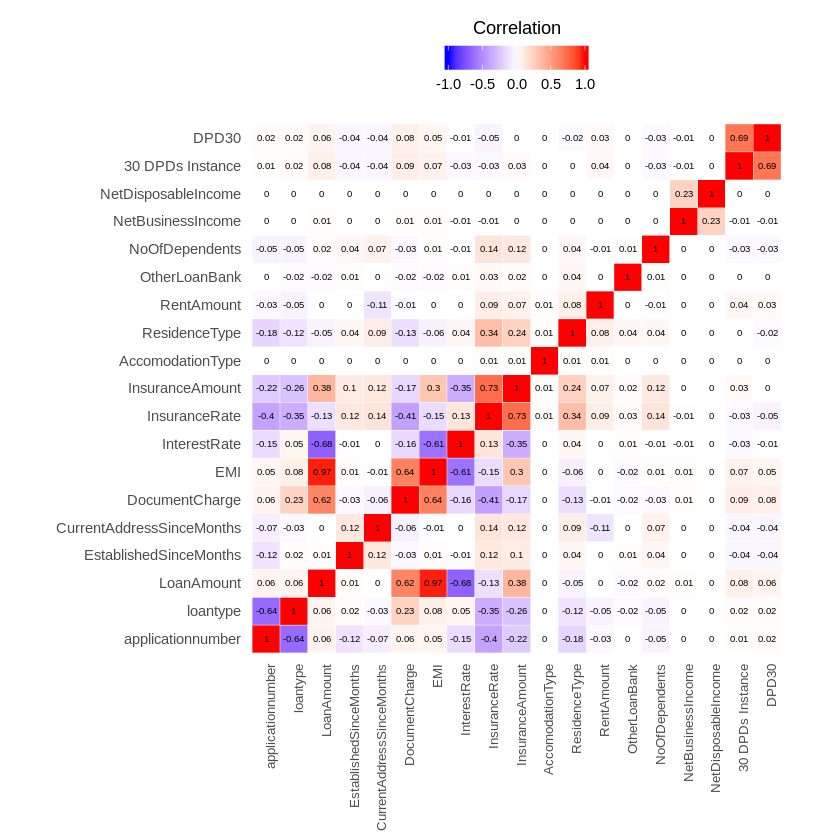

In [71]:
cormat <- round(cor(train %>% keep(is.numeric)),2)
melted_cormat <- melt(cormat)


ggheatmap <- ggplot(melted_cormat, aes(Var2, Var1, fill = value))+
 geom_tile(color = "white")+
 scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
   midpoint = 0, limit = c(-1,1), space = "Lab", 
    name="Correlation") +
  theme_minimal()+ # minimal theme
 theme(axis.text.x = element_text(angle = 90, vjust = 1, size = 8, hjust = 1))+
 coord_fixed()



ggheatmap + 
geom_text(aes(Var2, Var1, label = value), color = "black", size = 2, data = melted_cormat) +
theme(
  axis.title.x = element_blank(),
  axis.title.y = element_blank(),
  panel.grid.major = element_blank(),
  panel.border = element_blank(),
  panel.background = element_blank(),
  axis.ticks = element_blank(),
  legend.position="top",
  legend.direction = "horizontal")+
  guides(fill = guide_colorbar(barwidth = 6, barheight = 1,
                title.position = "top", title.hjust = 0.5))

In [5]:
# train <- read.csv("train_3.csv")
# train <- train[,3:ncol(train)-1]

# test <- read.csv("test_3.csv")
# test <- test[,3:ncol(test)-1]

corrplot 0.84 loaded


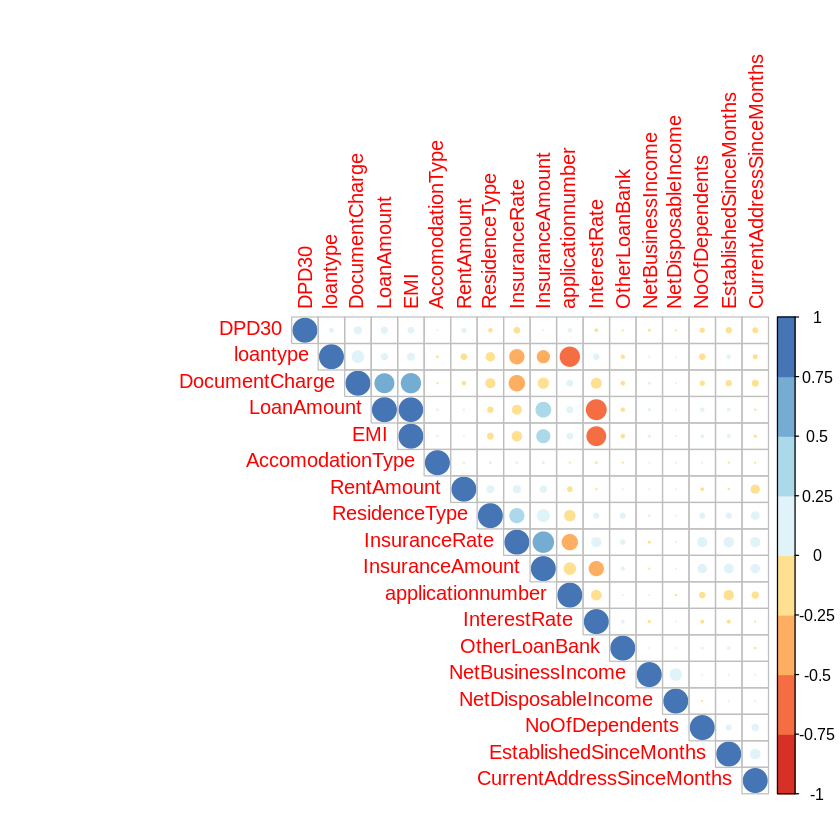

In [58]:
M <-cor(train %>% keep(is.numeric))
corrplot(M, type="upper", order="hclust",
         col=brewer.pal(n=8, name="RdYlBu"))

In [59]:
prop.table(table(train$DPD30))


       0        1 
0.889689 0.110311 

# <center><font color='red' size=15>conclusion</font>
### binry classification ka problam tha, to pehly logistic regression try kya, sary variables k sath model kya to pata chala k is tarah to koi bhi variable significant nahi h, phir most significat utha kar usy alag sy model kkya tab bhi wohi result, phir us variable ko transform kar k model kya tab bhi koi farq nahi aaya, to ham ny Logistic regression ko chor dya.
### LR k baad kNN use karny ka socha, magar KNN zyada variables k sath acha perform nahi karta (yahan hamary pas 25 variables hen, jin me factor variables bhi include hen, agar KNN chalaen gy to pehly in factory Variables k dummy variables banaen gy, is tarah hamar P kafi bara ho jay ga, jis k sath to KNN bilkul acha perform nahi kary ga.
### Random Forest: phir RF try kya, sary data k oper model train kya, magar accuracy 89% (jo k base line ki accuracy h) sy zyada nahi hwi, to model ko balanced kara, is tarah training data kam ho gya. phir is data par RF chalaya tab bhi accuracy me increase nahi hwa.